In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
import locale
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Function to format currency in Indian format (e.g., ₹12,50,000)
def format_inr(amount):
    if pd.isna(amount):
        return "₹0"

    amount = float(amount)
    if amount == 0:
        return "₹0"

    s = str(int(amount))
    result = s[-3:]
    s = s[:-3]

    while s:
        result = s[-2:] + ',' + result if len(s) >= 2 else s + ',' + result
        s = s[:-2]

    return f"₹{result}"

# 1. Data Preprocessing
print("🔄 Loading and preprocessing data...")

# Load the dataset
url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/ds_salaries%20%281%29-uBxgrOMw5QFQp6IU9ErTKutI70vMvV.csv"
df = pd.read_csv(url)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Convert salary_in_usd to salary_in_inr (1 USD = 83 INR)
df['salary_in_inr'] = df['salary_in_usd'].astype(float) * 83

# Drop the USD salary column
df.drop('salary_in_usd', axis=1, inplace=True)



🔄 Loading and preprocessing data...
Dataset shape: (3755, 11)

First few rows of the dataset:
   work_year experience_level employment_type                 job_title  salary salary_currency  salary_in_usd employee_residence  remote_ratio company_location company_size
0       2023               SE              FT  Principal Data Scientist   80000             EUR          85847                 ES           100               ES            L
1       2023               MI              CT               ML Engineer   30000             USD          30000                 US           100               US            S
2       2023               MI              CT               ML Engineer   25500             USD          25500                 US           100               US            S
3       2023               SE              FT            Data Scientist  175000             USD         175000                 CA           100               CA            M
4       2023               SE       


Renamed columns:
['year', 'experience', 'employment', 'job_title', 'original_salary', 'currency', 'residence', 'remote_percentage', 'company_country', 'company_size', 'salary_in_inr']

Encoding for experience:
  EN -> 0
  EX -> 1
  MI -> 2
  SE -> 3

Encoding for employment:
  CT -> 0
  FL -> 1
  FT -> 2
  PT -> 3

Encoding for job_title:
  3D Computer Vision Researcher -> 0
  AI Developer -> 1
  AI Programmer -> 2
  AI Scientist -> 3
  Analytics Engineer -> 4
  Applied Data Scientist -> 5
  Applied Machine Learning Engineer -> 6
  Applied Machine Learning Scientist -> 7
  Applied Scientist -> 8
  Autonomous Vehicle Technician -> 9
  Azure Data Engineer -> 10
  BI Analyst -> 11
  BI Data Analyst -> 12
  BI Data Engineer -> 13
  BI Developer -> 14
  Big Data Architect -> 15
  Big Data Engineer -> 16
  Business Data Analyst -> 17
  Business Intelligence Engineer -> 18
  Cloud Data Architect -> 19
  Cloud Data Engineer -> 20
  Cloud Database Engineer -> 21
  Compliance Data Analyst -> 22

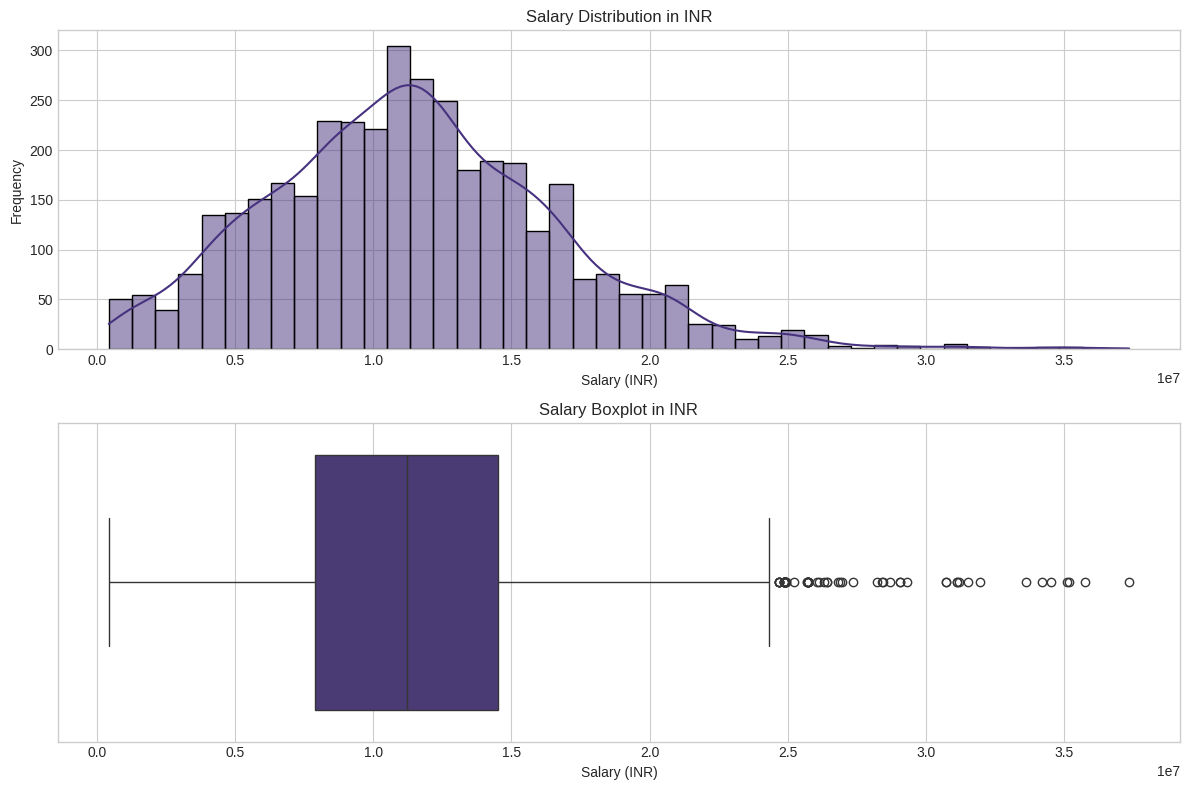

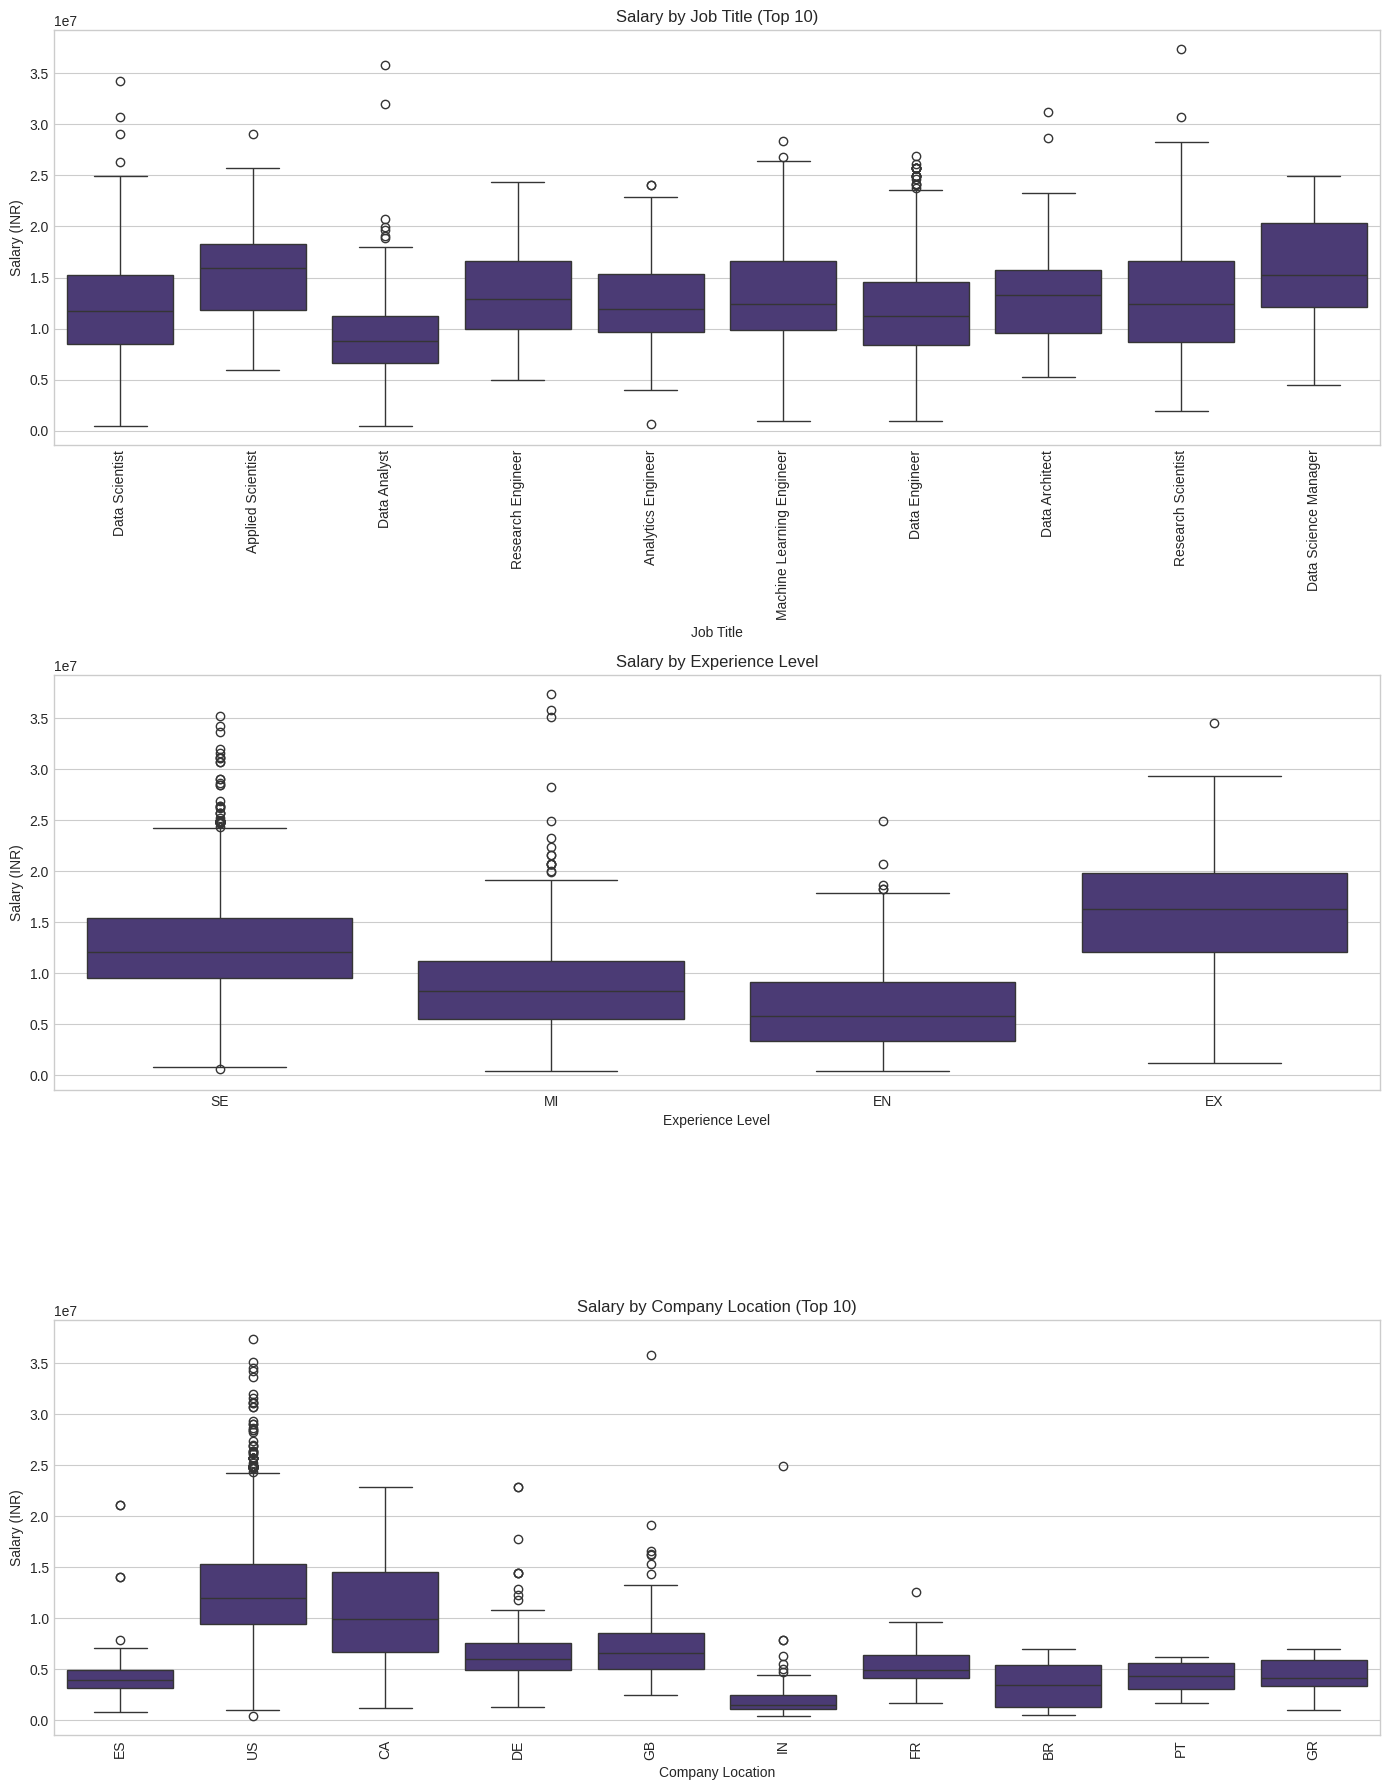

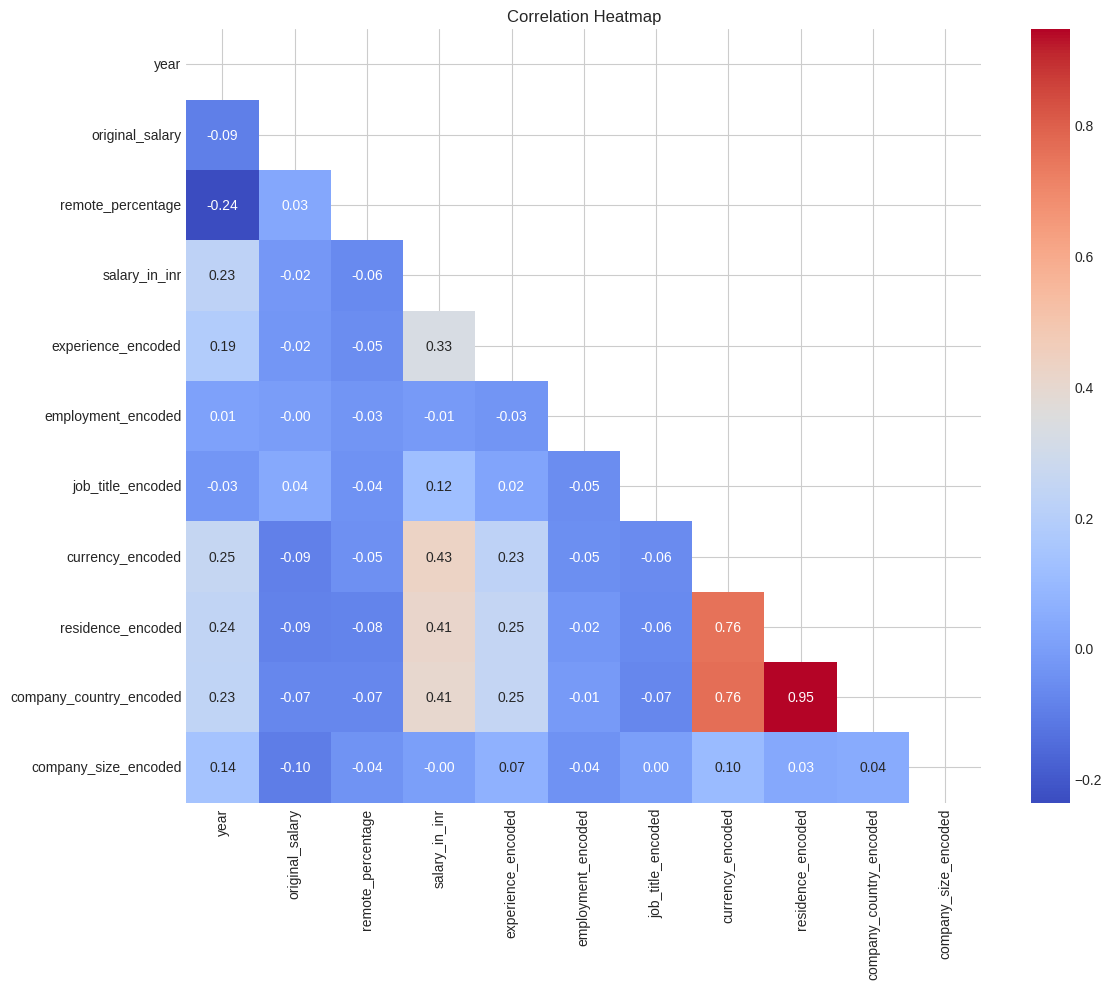

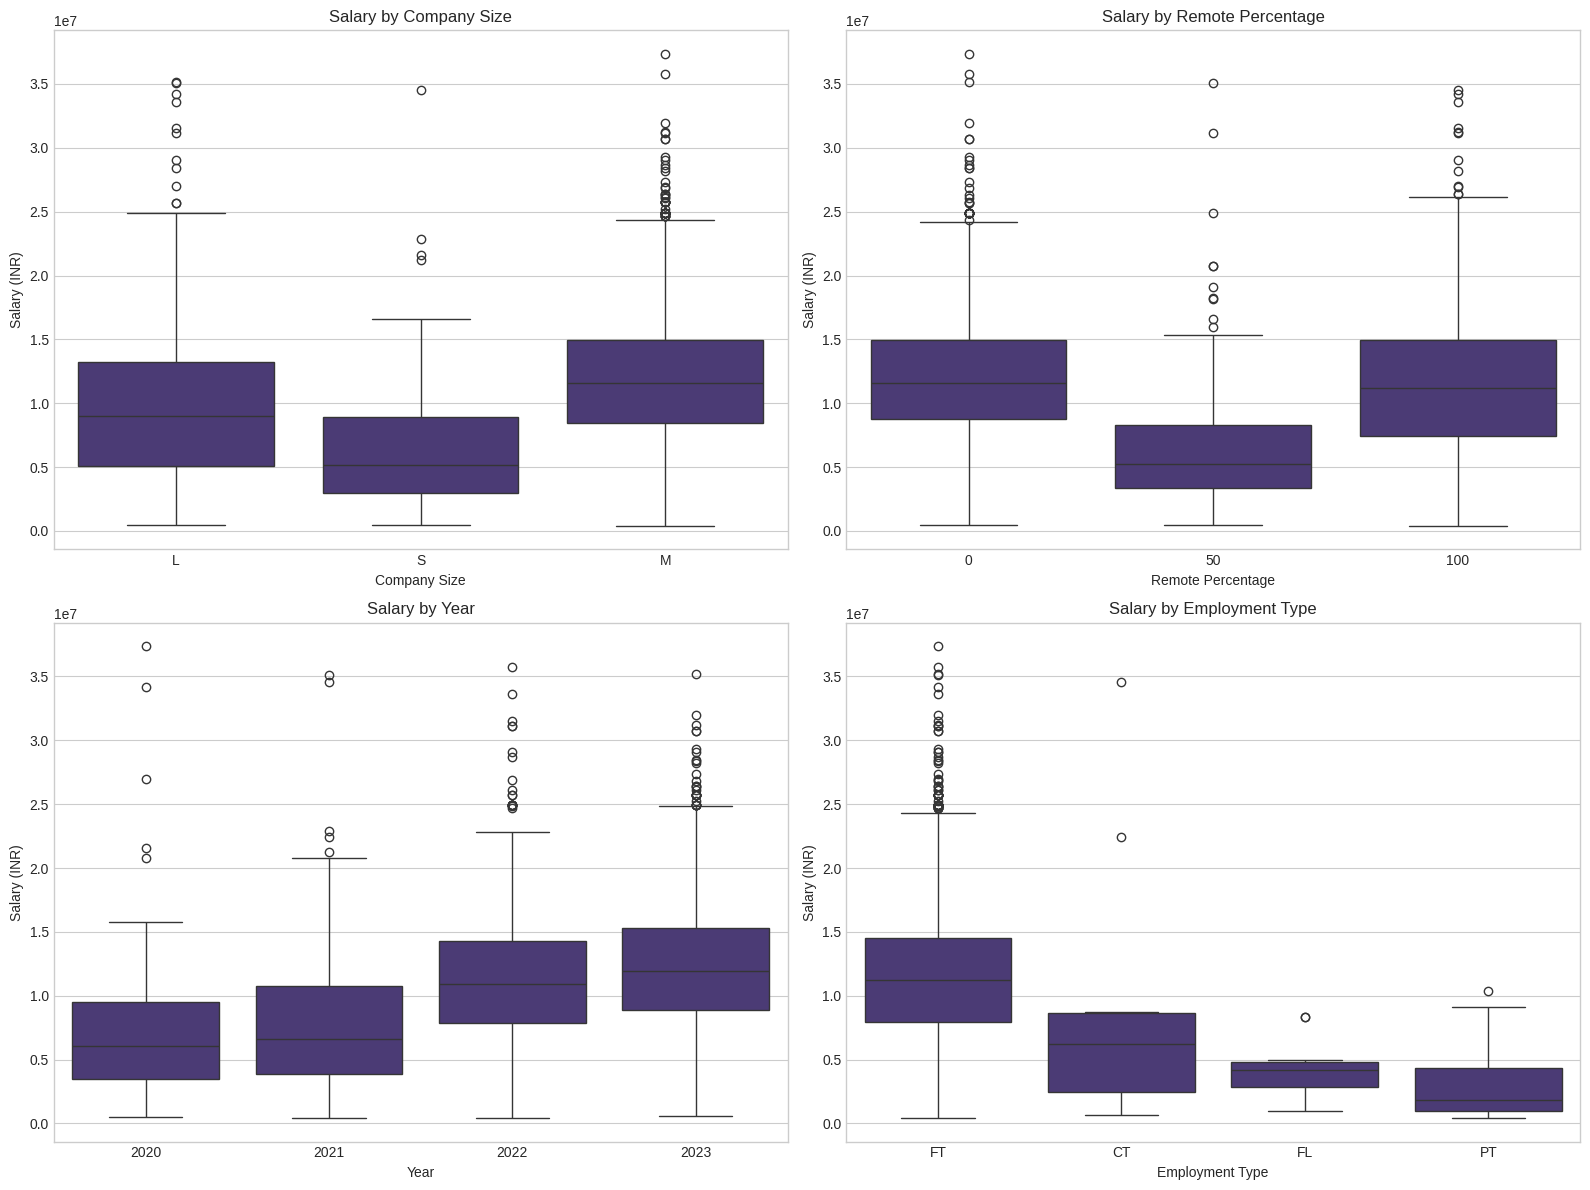



🤖 Training regression models...

Training Linear Regression...
  MAE: ₹₹34,08,495
  RMSE: ₹₹43,50,624
  R²: 0.3040

Training Decision Tree...
  MAE: ₹₹32,91,052
  RMSE: ₹₹44,15,989
  R²: 0.2830

Training Random Forest...
  MAE: ₹₹30,73,581
  RMSE: ₹₹40,82,458
  R²: 0.3872

Training XGBoost...
  MAE: ₹₹30,99,299
  RMSE: ₹₹41,47,982
  R²: 0.3673

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 8
[LightGBM] [Info] Start training from score 11458647.115846
  MAE: ₹₹30,35,853
  RMSE: ₹₹39,94,543
  R²: 0.4133

Training SVR...
  MAE: ₹₹40,30,427
  RMSE: ₹₹52,15,269
  R²: -0.0001

Training MLP Regressor...
  MAE: ₹₹39,70,381
  RMSE: ₹₹51,05,325
  R²: 0.0416


In [2]:
# Rename columns for clarity
df = df.rename(columns={
    'work_year': 'year',
    'experience_level': 'experience',
    'employment_type': 'employment',
    'job_title': 'job_title',
    'salary': 'original_salary',
    'salary_currency': 'currency',
    'employee_residence': 'residence',
    'remote_ratio': 'remote_percentage',
    'company_location': 'company_country',
    'company_size': 'company_size'
})

# Display the renamed columns
print("\nRenamed columns:")
print(df.columns.tolist())

# Encode categorical variables
categorical_columns = ['experience', 'employment', 'job_title', 'currency',
                      'residence', 'company_country', 'company_size']

# Create a dictionary to store the label encoders
label_encoders = {}

# Apply label encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

    # Print mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\nEncoding for {col}:")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")

# Create dummy variables for job titles (one-hot encoding)
job_dummies = pd.get_dummies(df['job_title'], prefix='job')
df = pd.concat([df, job_dummies], axis=1)

# 2. Exploratory Data Analysis (EDA)
print("\n\n📊 Performing Exploratory Data Analysis...")

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure for the salary distribution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.histplot(df['salary_in_inr'], kde=True)
plt.title('Salary Distribution in INR')
plt.xlabel('Salary (INR)')
plt.ylabel('Frequency')

# Add a boxplot for the salary distribution
plt.subplot(2, 1, 2)
sns.boxplot(x=df['salary_in_inr'])
plt.title('Salary Boxplot in INR')
plt.xlabel('Salary (INR)')
plt.tight_layout()
plt.show()

# Create boxplots for categorical variables vs salary
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Top 10 job titles by frequency
top_jobs = df['job_title'].value_counts().head(10).index
job_salary_data = df[df['job_title'].isin(top_jobs)]

sns.boxplot(x='job_title', y='salary_in_inr', data=job_salary_data, ax=axes[0])
axes[0].set_title('Salary by Job Title (Top 10)')
axes[0].set_xlabel('Job Title')
axes[0].set_ylabel('Salary (INR)')
axes[0].tick_params(axis='x', rotation=90)

# Experience vs Salary
sns.boxplot(x='experience', y='salary_in_inr', data=df, ax=axes[1])
axes[1].set_title('Salary by Experience Level')
axes[1].set_xlabel('Experience Level')
axes[1].set_ylabel('Salary (INR)')

# Top 10 company locations by frequency
top_locations = df['company_country'].value_counts().head(10).index
location_salary_data = df[df['company_country'].isin(top_locations)]

sns.boxplot(x='company_country', y='salary_in_inr', data=location_salary_data, ax=axes[2])
axes[2].set_title('Salary by Company Location (Top 10)')
axes[2].set_xlabel('Company Location')
axes[2].set_ylabel('Salary (INR)')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Create correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Additional plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Salary by company size
sns.boxplot(x='company_size', y='salary_in_inr', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Salary by Company Size')
axes[0, 0].set_xlabel('Company Size')
axes[0, 0].set_ylabel('Salary (INR)')

# Salary by remote ratio
sns.boxplot(x='remote_percentage', y='salary_in_inr', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Salary by Remote Percentage')
axes[0, 1].set_xlabel('Remote Percentage')
axes[0, 1].set_ylabel('Salary (INR)')

# Salary by work year
sns.boxplot(x='year', y='salary_in_inr', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Salary by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Salary (INR)')

# Salary by employment type
sns.boxplot(x='employment', y='salary_in_inr', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Salary by Employment Type')
axes[1, 1].set_xlabel('Employment Type')
axes[1, 1].set_ylabel('Salary (INR)')

plt.tight_layout()
plt.show()

# 3. Model Training
print("\n\n🤖 Training regression models...")

# Prepare the data for modeling
X = df.select_dtypes(include=[np.number])
X = X.drop(['salary_in_inr', 'original_salary'], axis=1, errors='ignore')
y = df['salary_in_inr']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'model': model
    }

    print(f"  MAE: ₹{format_inr(mae)}")
    print(f"  RMSE: ₹{format_inr(rmse)}")
    print(f"  R²: {r2:.4f}")

    # Check if this is the best model so far
    if r2 > best_score:
        best_score = r2
        best_model = name




📈 Model Evaluation Results:

Model comparison:
               Model           MAE          RMSE        R²
4           LightGBM  3.035853e+06  3.994544e+06  0.413289
2      Random Forest  3.073581e+06  4.082459e+06  0.387179
3            XGBoost  3.099300e+06  4.147982e+06  0.367350
0  Linear Regression  3.408495e+06  4.350625e+06  0.304026
1      Decision Tree  3.291052e+06  4.415990e+06  0.282956
6      MLP Regressor  3.970381e+06  5.105325e+06  0.041622
5                SVR  4.030427e+06  5.215270e+06 -0.000100


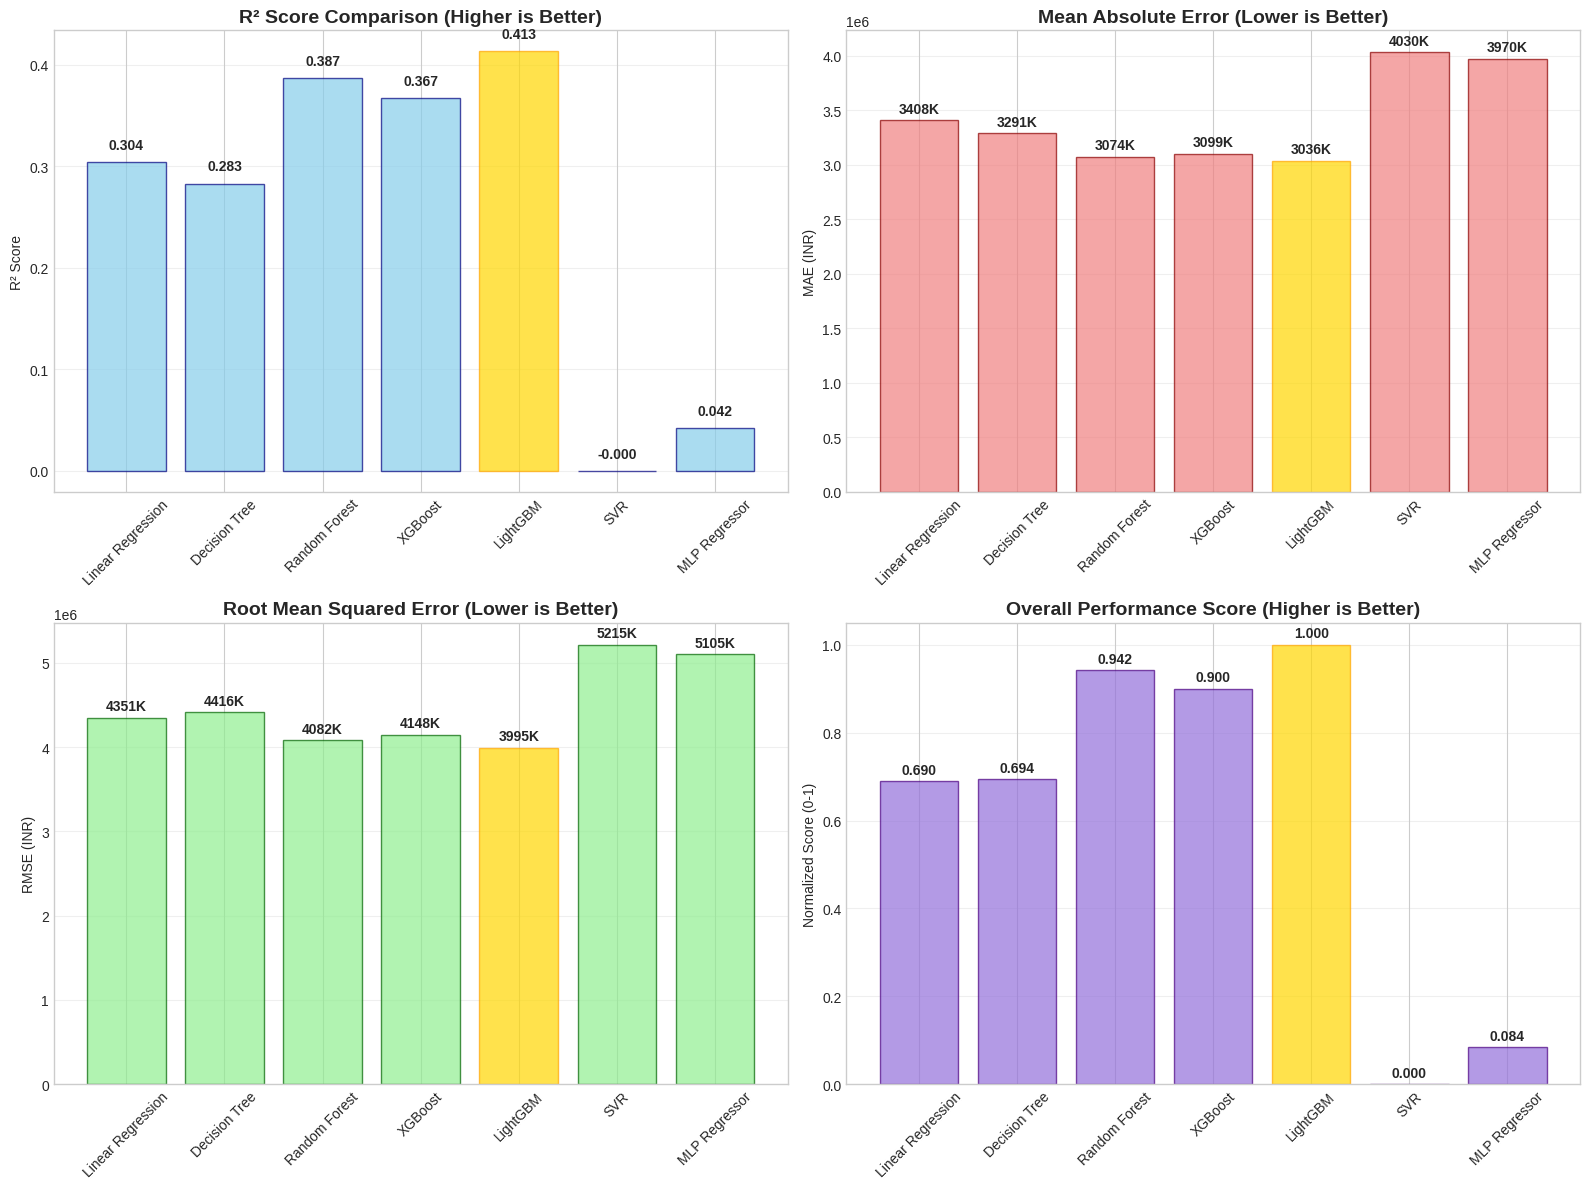


🏆 DETAILED MODEL PERFORMANCE RANKING:
            Model  R² Score  MAE (INR) RMSE (INR)  Overall Score  R² Rank  MAE Rank  RMSE Rank  Overall Rank
         LightGBM  0.413289 ₹30,35,853 ₹39,94,543       1.000000        1         1          1             1
    Random Forest  0.387179 ₹30,73,581 ₹40,82,458       0.942296        2         2          2             2
          XGBoost  0.367350 ₹30,99,299 ₹41,47,982       0.899795        3         3          3             3
    Decision Tree  0.282956 ₹32,91,052 ₹44,15,989       0.694296        5         4          5             4
Linear Regression  0.304026 ₹34,08,495 ₹43,50,624       0.689773        4         5          4             5
    MLP Regressor  0.041622 ₹39,70,381 ₹51,05,325       0.083789        6         6          6             6
              SVR -0.000100 ₹40,30,427 ₹52,15,269       0.000000        7         7          7             7

🥇 WINNER: LightGBM
   R² Score: 0.4133
   MAE: ₹30,35,853
   RMSE: ₹39,94,543
   Overall

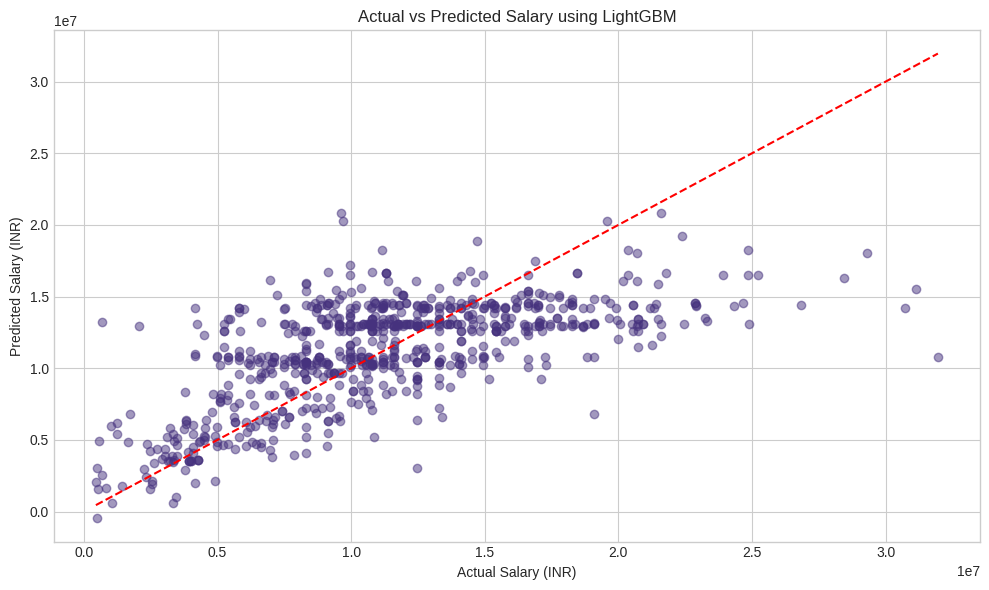



🏆 Best Model: LightGBM with R² score of 0.4133
Model saved as 'salary_model.pkl'


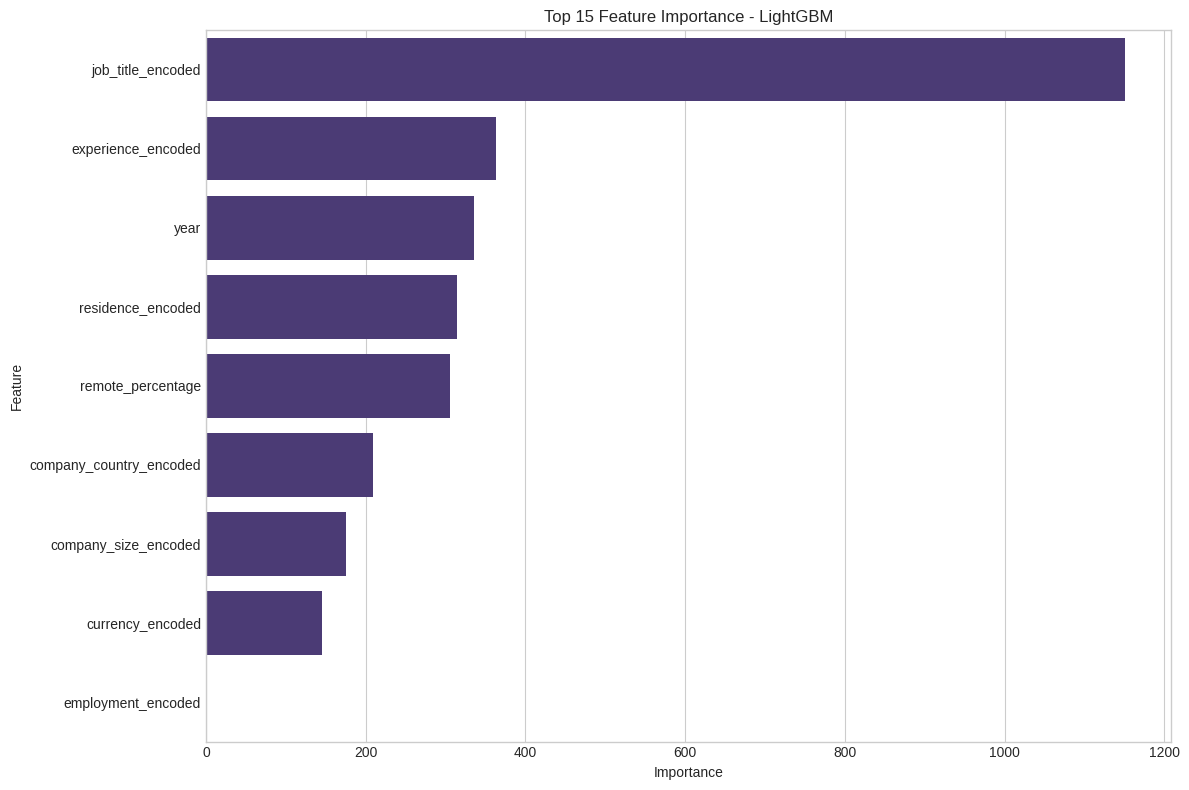


Top 10 most important features:
                   Feature  Importance
4        job_title_encoded        1151
2       experience_encoded         363
0                     year         336
6        residence_encoded         315
1        remote_percentage         306
7  company_country_encoded         209
8     company_size_encoded         175
5         currency_encoded         145
3       employment_encoded           0

✅ Summary Statistics of Salaries (INR):
Mean Salary: ₹1,14,18,342
Median Salary: ₹1,12,05,000
Min Salary: ₹4,25,956
Max Salary: ₹3,73,50,000
25th Percentile: ₹78,85,000
75th Percentile: ₹1,45,25,000

Done! All tasks completed successfully.


In [3]:

# 4. Model Evaluation
print("\n\n📈 Model Evaluation Results:")
print("\nModel comparison:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'R²': [results[model]['R²'] for model in results]
})
comparison_df = comparison_df.sort_values('R²', ascending=False)
print(comparison_df)

# Format the MAE and RMSE columns in INR format
comparison_df['MAE (INR)'] = comparison_df['MAE'].apply(format_inr)
comparison_df['RMSE (INR)'] = comparison_df['RMSE'].apply(format_inr)
comparison_df = comparison_df.drop(['MAE', 'RMSE'], axis=1)

# Create comprehensive model comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score comparison (higher is better)
r2_scores = [results[model]['R²'] for model in results]
model_names = list(results.keys())

bars1 = axes[0, 0].bar(model_names, r2_scores, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_title('R² Score Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars1, r2_scores):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best model
best_idx = r2_scores.index(max(r2_scores))
bars1[best_idx].set_color('gold')
bars1[best_idx].set_edgecolor('orange')

# 2. MAE comparison (lower is better)
mae_scores = [results[model]['MAE'] for model in results]
bars2 = axes[0, 1].bar(model_names, mae_scores, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[0, 1].set_title('Mean Absolute Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MAE (INR)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mae in zip(bars2, mae_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + max(mae_scores)*0.01,
                    f'{mae/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest MAE)
best_mae_idx = mae_scores.index(min(mae_scores))
bars2[best_mae_idx].set_color('gold')
bars2[best_mae_idx].set_edgecolor('orange')

# 3. RMSE comparison (lower is better)
rmse_scores = [results[model]['RMSE'] for model in results]
bars3 = axes[1, 0].bar(model_names, rmse_scores, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[1, 0].set_title('Root Mean Squared Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('RMSE (INR)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rmse in zip(bars3, rmse_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(rmse_scores)*0.01,
                    f'{rmse/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest RMSE)
best_rmse_idx = rmse_scores.index(min(rmse_scores))
bars3[best_rmse_idx].set_color('gold')
bars3[best_rmse_idx].set_edgecolor('orange')

# 4. Combined performance radar chart style comparison
# Normalize scores for better comparison (0-1 scale)
normalized_r2 = [(score - min(r2_scores)) / (max(r2_scores) - min(r2_scores)) for score in r2_scores]
normalized_mae = [1 - (score - min(mae_scores)) / (max(mae_scores) - min(mae_scores)) for score in mae_scores]  # Inverted because lower is better
normalized_rmse = [1 - (score - min(rmse_scores)) / (max(rmse_scores) - min(rmse_scores)) for score in rmse_scores]  # Inverted because lower is better

# Calculate overall performance score
overall_scores = [(r2 + mae + rmse) / 3 for r2, mae, rmse in zip(normalized_r2, normalized_mae, normalized_rmse)]

bars4 = axes[1, 1].bar(model_names, overall_scores, color='mediumpurple', edgecolor='indigo', alpha=0.7)
axes[1, 1].set_title('Overall Performance Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Normalized Score (0-1)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars4, overall_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best overall model
best_overall_idx = overall_scores.index(max(overall_scores))
bars4[best_overall_idx].set_color('gold')
bars4[best_overall_idx].set_edgecolor('orange')

plt.tight_layout()
plt.show()

# Print detailed comparison table with rankings
print("\n🏆 DETAILED MODEL PERFORMANCE RANKING:")
print("=" * 80)

ranking_df = pd.DataFrame({
    'Model': model_names,
    'R² Score': r2_scores,
    'MAE (INR)': [format_inr(mae) for mae in mae_scores],
    'RMSE (INR)': [format_inr(rmse) for rmse in rmse_scores],
    'Overall Score': overall_scores
})

# Add rankings
ranking_df['R² Rank'] = ranking_df['R² Score'].rank(ascending=False).astype(int)
ranking_df['MAE Rank'] = pd.Series(mae_scores).rank(ascending=True).astype(int)
ranking_df['RMSE Rank'] = pd.Series(rmse_scores).rank(ascending=True).astype(int)
ranking_df['Overall Rank'] = ranking_df['Overall Score'].rank(ascending=False).astype(int)

# Sort by overall rank
ranking_df = ranking_df.sort_values('Overall Rank')

print(ranking_df.to_string(index=False))

# Highlight the winner
best_model_overall = ranking_df.iloc[0]['Model']
print(f"\n🥇 WINNER: {best_model_overall}")
print(f"   R² Score: {ranking_df.iloc[0]['R² Score']:.4f}")
print(f"   MAE: {ranking_df.iloc[0]['MAE (INR)']}")
print(f"   RMSE: {ranking_df.iloc[0]['RMSE (INR)']}")
print(f"   Overall Score: {ranking_df.iloc[0]['Overall Score']:.4f}")

# Plot actual vs predicted values for the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_obj = results[best_model_name]['model']

y_pred = best_model_obj.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary (INR)')
plt.ylabel('Predicted Salary (INR)')
plt.title(f'Actual vs Predicted Salary using {best_model_name}')
plt.tight_layout()
plt.show()

# 5. Save the best model
print(f"\n\n🏆 Best Model: {best_model_name} with R² score of {results[best_model_name]['R²']:.4f}")
joblib.dump(results[best_model_name]['model'], 'salary_model.pkl')
print("Model saved as 'salary_model.pkl'")

# Feature importance for the best model (if applicable)
if best_model_name in ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']:
    feature_importance = None

    if best_model_name == 'Decision Tree':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'Random Forest':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'XGBoost':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'LightGBM':
        feature_importance = results[best_model_name]['model'].feature_importances_

    if feature_importance is not None:
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
        plt.title(f'Top 15 Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.show()

        print("\nTop 10 most important features:")
        print(feature_importance_df.head(10))

# Summary statistics of salaries in INR
print("\n✅ Summary Statistics of Salaries (INR):")
salary_stats = df['salary_in_inr'].describe()
print(f"Mean Salary: {format_inr(salary_stats['mean'])}")
print(f"Median Salary: {format_inr(df['salary_in_inr'].median())}")
print(f"Min Salary: {format_inr(salary_stats['min'])}")
print(f"Max Salary: {format_inr(salary_stats['max'])}")
print(f"25th Percentile: {format_inr(salary_stats['25%'])}")
print(f"75th Percentile: {format_inr(salary_stats['75%'])}")




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
import locale
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Function to format currency in Indian format (e.g., ₹12,50,000)
def format_inr(amount):
    if pd.isna(amount):
        return "₹0"

    amount = float(amount)
    if amount == 0:
        return "₹0"

    s = str(int(amount))
    result = s[-3:]
    s = s[:-3]

    while s:
        result = s[-2:] + ',' + result if len(s) >= 2 else s + ',' + result
        s = s[:-2]

    return f"₹{result}"

# Function to get user input for salary prediction
def get_user_input(df, label_encoders):
    print("\n" + "="*60)
    print("💰 SALARY PREDICTION - Enter Your Details")
    print("="*60)

    user_data = {}

    # Work Year
    print(f"\n📅 Available work years: {sorted(df['year'].unique())}")
    while True:
        try:
            year = int(input("Enter work year (e.g., 2023): "))
            if year in df['year'].unique():
                user_data['year'] = year
                break
            else:
                print(f"Please enter a valid year from: {sorted(df['year'].unique())}")
        except ValueError:
            print("Please enter a valid number for year.")

    # Experience Level
    print(f"\n🎯 Available experience levels:")
    exp_options = df['experience'].unique()
    for i, exp in enumerate(exp_options, 1):
        print(f"  {i}. {exp}")

    while True:
        try:
            exp_choice = int(input(f"Select experience level (1-{len(exp_options)}): ")) - 1
            if 0 <= exp_choice < len(exp_options):
                experience = exp_options[exp_choice]
                user_data['experience'] = experience
                user_data['experience_encoded'] = label_encoders['experience'].transform([experience])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(exp_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Employment Type
    print(f"\n💼 Available employment types:")
    emp_options = df['employment'].unique()
    for i, emp in enumerate(emp_options, 1):
        print(f"  {i}. {emp}")

    while True:
        try:
            emp_choice = int(input(f"Select employment type (1-{len(emp_options)}): ")) - 1
            if 0 <= emp_choice < len(emp_options):
                employment = emp_options[emp_choice]
                user_data['employment'] = employment
                user_data['employment_encoded'] = label_encoders['employment'].transform([employment])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(emp_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Job Title
    print(f"\n🚀 Available job titles (showing top 20 most common):")
    job_options = df['job_title'].value_counts().head(20).index.tolist()
    for i, job in enumerate(job_options, 1):
        print(f"  {i}. {job}")

    while True:
        try:
            job_choice = int(input(f"Select job title (1-{len(job_options)}): ")) - 1
            if 0 <= job_choice < len(job_options):
                job_title = job_options[job_choice]
                user_data['job_title'] = job_title
                user_data['job_title_encoded'] = label_encoders['job_title'].transform([job_title])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(job_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Company Size
    print(f"\n🏢 Available company sizes:")
    size_options = df['company_size'].unique()
    for i, size in enumerate(size_options, 1):
        print(f"  {i}. {size}")

    while True:
        try:
            size_choice = int(input(f"Select company size (1-{len(size_options)}): ")) - 1
            if 0 <= size_choice < len(size_options):
                company_size = size_options[size_choice]
                user_data['company_size'] = company_size
                user_data['company_size_encoded'] = label_encoders['company_size'].transform([company_size])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(size_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Remote Percentage
    print(f"\n🏠 Available remote work percentages: {sorted(df['remote_percentage'].unique())}")
    while True:
        try:
            remote = int(input("Enter remote work percentage (0, 50, or 100): "))
            if remote in df['remote_percentage'].unique():
                user_data['remote_percentage'] = remote
                break
            else:
                print(f"Please enter a valid remote percentage from: {sorted(df['remote_percentage'].unique())}")
        except ValueError:
            print("Please enter a valid number.")

    # Company Country
    print(f"\n🌍 Available company countries (showing top 15 most common):")
    country_options = df['company_country'].value_counts().head(15).index.tolist()
    for i, country in enumerate(country_options, 1):
        print(f"  {i}. {country}")

    while True:
        try:
            country_choice = int(input(f"Select company country (1-{len(country_options)}): ")) - 1
            if 0 <= country_choice < len(country_options):
                company_country = country_options[country_choice]
                user_data['company_country'] = company_country
                user_data['company_country_encoded'] = label_encoders['company_country'].transform([company_country])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(country_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Employee Residence
    print(f"\n🏡 Available employee residence countries (showing top 15 most common):")
    residence_options = df['residence'].value_counts().head(15).index.tolist()
    for i, residence in enumerate(residence_options, 1):
        print(f"  {i}. {residence}")

    while True:
        try:
            residence_choice = int(input(f"Select employee residence (1-{len(residence_options)}): ")) - 1
            if 0 <= residence_choice < len(residence_options):
                residence = residence_options[residence_choice]
                user_data['residence'] = residence
                user_data['residence_encoded'] = label_encoders['residence'].transform([residence])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(residence_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Currency (most common ones)
    print(f"\n💱 Available salary currencies:")
    currency_options = df['currency'].unique()
    for i, currency in enumerate(currency_options, 1):
        print(f"  {i}. {currency}")

    while True:
        try:
            currency_choice = int(input(f"Select salary currency (1-{len(currency_options)}): ")) - 1
            if 0 <= currency_choice < len(currency_options):
                currency = currency_options[currency_choice]
                user_data['currency'] = currency
                user_data['currency_encoded'] = label_encoders['currency'].transform([currency])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(currency_options)}")
        except ValueError:
            print("Please enter a valid number.")

    return user_data

# Function to prepare user input for prediction
def prepare_user_input_for_prediction(user_data, X_columns, df):
    # Create a dataframe with user input
    user_df = pd.DataFrame([user_data])

    # Create the same structure as training data
    prediction_input = pd.DataFrame(columns=X_columns, index=[0])
    prediction_input = prediction_input.fillna(0)

    # Fill in the encoded values
    prediction_input.loc[0, 'year'] = user_data['year']
    prediction_input.loc[0, 'experience_encoded'] = user_data['experience_encoded']
    prediction_input.loc[0, 'employment_encoded'] = user_data['employment_encoded']
    prediction_input.loc[0, 'job_title_encoded'] = user_data['job_title_encoded']
    prediction_input.loc[0, 'currency_encoded'] = user_data['currency_encoded']
    prediction_input.loc[0, 'residence_encoded'] = user_data['residence_encoded']
    prediction_input.loc[0, 'remote_percentage'] = user_data['remote_percentage']
    prediction_input.loc[0, 'company_country_encoded'] = user_data['company_country_encoded']
    prediction_input.loc[0, 'company_size_encoded'] = user_data['company_size_encoded']

    # Handle job title one-hot encoding
    job_column = f"job_{user_data['job_title']}"
    if job_column in X_columns:
        prediction_input.loc[0, job_column] = 1

    return prediction_input

# 1. Data Preprocessing
print("🔄 Loading and preprocessing data...")

# Load the dataset
url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/ds_salaries%20%281%29-uBxgrOMw5QFQp6IU9ErTKutI70vMvV.csv"
df = pd.read_csv(url)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Convert salary_in_usd to salary_in_inr (1 USD = 83 INR)
df['salary_in_inr'] = df['salary_in_usd'].astype(float) * 83

# Drop the USD salary column
df.drop('salary_in_usd', axis=1, inplace=True)

# Rename columns for clarity
df = df.rename(columns={
    'work_year': 'year',
    'experience_level': 'experience',
    'employment_type': 'employment',
    'job_title': 'job_title',
    'salary': 'original_salary',
    'salary_currency': 'currency',
    'employee_residence': 'residence',
    'remote_ratio': 'remote_percentage',
    'company_location': 'company_country',
    'company_size': 'company_size'
})

# Display the renamed columns
print("\nRenamed columns:")
print(df.columns.tolist())

# Encode categorical variables
categorical_columns = ['experience', 'employment', 'job_title', 'currency',
                      'residence', 'company_country', 'company_size']

# Create a dictionary to store the label encoders
label_encoders = {}

# Apply label encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

    # Print mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\nEncoding for {col}:")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")

# Create dummy variables for job titles (one-hot encoding)
job_dummies = pd.get_dummies(df['job_title'], prefix='job')
df = pd.concat([df, job_dummies], axis=1)

# 2. Exploratory Data Analysis (EDA)
print("\n\n📊 Performing Exploratory Data Analysis...")

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure for the salary distribution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.histplot(df['salary_in_inr'], kde=True)
plt.title('Salary Distribution in INR')
plt.xlabel('Salary (INR)')
plt.ylabel('Frequency')

# Add a boxplot for the salary distribution
plt.subplot(2, 1, 2)
sns.boxplot(x=df['salary_in_inr'])
plt.title('Salary Boxplot in INR')
plt.xlabel('Salary (INR)')
plt.tight_layout()
plt.show()

# Create boxplots for categorical variables vs salary
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Top 10 job titles by frequency
top_jobs = df['job_title'].value_counts().head(10).index
job_salary_data = df[df['job_title'].isin(top_jobs)]

sns.boxplot(x='job_title', y='salary_in_inr', data=job_salary_data, ax=axes[0])
axes[0].set_title('Salary by Job Title (Top 10)')
axes[0].set_xlabel('Job Title')
axes[0].set_ylabel('Salary (INR)')
axes[0].tick_params(axis='x', rotation=90)

# Experience vs Salary
sns.boxplot(x='experience', y='salary_in_inr', data=df, ax=axes[1])
axes[1].set_title('Salary by Experience Level')
axes[1].set_xlabel('Experience Level')
axes[1].set_ylabel('Salary (INR)')

# Top 10 company locations by frequency
top_locations = df['company_country'].value_counts().head(10).index
location_salary_data = df[df['company_country'].isin(top_locations)]

sns.boxplot(x='company_country', y='salary_in_inr', data=location_salary_data, ax=axes[2])
axes[2].set_title('Salary by Company Location (Top 10)')
axes[2].set_xlabel('Company Location')
axes[2].set_ylabel('Salary (INR)')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Create correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Additional plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Salary by company size
sns.boxplot(x='company_size', y='salary_in_inr', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Salary by Company Size')
axes[0, 0].set_xlabel('Company Size')
axes[0, 0].set_ylabel('Salary (INR)')

# Salary by remote ratio
sns.boxplot(x='remote_percentage', y='salary_in_inr', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Salary by Remote Percentage')
axes[0, 1].set_xlabel('Remote Percentage')
axes[0, 1].set_ylabel('Salary (INR)')

# Salary by work year
sns.boxplot(x='year', y='salary_in_inr', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Salary by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Salary (INR)')

# Salary by employment type
sns.boxplot(x='employment', y='salary_in_inr', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Salary by Employment Type')
axes[1, 1].set_xlabel('Employment Type')
axes[1, 1].set_ylabel('Salary (INR)')

plt.tight_layout()
plt.show()

# 3. Model Training
print("\n\n🤖 Training regression models...")

# Prepare the data for modeling
X = df.select_dtypes(include=[np.number])
X = X.drop(['salary_in_inr', 'original_salary'], axis=1, errors='ignore')
y = df['salary_in_inr']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'model': model
    }

    print(f"  MAE: ₹{format_inr(mae)}")
    print(f"  RMSE: ₹{format_inr(rmse)}")
    print(f"  R²: {r2:.4f}")

    # Check if this is the best model so far
    if r2 > best_score:
        best_score = r2
        best_model = name

# 4. Model Evaluation
print("\n\n📈 Model Evaluation Results:")
print("\nModel comparison:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'R²': [results[model]['R²'] for model in results]
})
comparison_df = comparison_df.sort_values('R²', ascending=False)
print(comparison_df)

# Format the MAE and RMSE columns in INR format
comparison_df['MAE (INR)'] = comparison_df['MAE'].apply(format_inr)
comparison_df['RMSE (INR)'] = comparison_df['RMSE'].apply(format_inr)
comparison_df = comparison_df.drop(['MAE', 'RMSE'], axis=1)

# Create comprehensive model comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score comparison (higher is better)
r2_scores = [results[model]['R²'] for model in results]
model_names = list(results.keys())

bars1 = axes[0, 0].bar(model_names, r2_scores, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_title('R² Score Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars1, r2_scores):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best model
best_idx = r2_scores.index(max(r2_scores))
bars1[best_idx].set_color('gold')
bars1[best_idx].set_edgecolor('orange')

# 2. MAE comparison (lower is better)
mae_scores = [results[model]['MAE'] for model in results]
bars2 = axes[0, 1].bar(model_names, mae_scores, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[0, 1].set_title('Mean Absolute Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MAE (INR)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mae in zip(bars2, mae_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + max(mae_scores)*0.01,
                    f'{mae/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest MAE)
best_mae_idx = mae_scores.index(min(mae_scores))
bars2[best_mae_idx].set_color('gold')
bars2[best_mae_idx].set_edgecolor('orange')

# 3. RMSE comparison (lower is better)
rmse_scores = [results[model]['RMSE'] for model in results]
bars3 = axes[1, 0].bar(model_names, rmse_scores, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[1, 0].set_title('Root Mean Squared Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('RMSE (INR)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rmse in zip(bars3, rmse_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(rmse_scores)*0.01,
                    f'{rmse/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest RMSE)
best_rmse_idx = rmse_scores.index(min(rmse_scores))
bars3[best_rmse_idx].set_color('gold')
bars3[best_rmse_idx].set_edgecolor('orange')

# 4. Combined performance radar chart style comparison
# Normalize scores for better comparison (0-1 scale)
normalized_r2 = [(score - min(r2_scores)) / (max(r2_scores) - min(r2_scores)) for score in r2_scores]
normalized_mae = [1 - (score - min(mae_scores)) / (max(mae_scores) - min(mae_scores)) for score in mae_scores]  # Inverted because lower is better
normalized_rmse = [1 - (score - min(rmse_scores)) / (max(rmse_scores) - min(rmse_scores)) for score in rmse_scores]  # Inverted because lower is better

# Calculate overall performance score
overall_scores = [(r2 + mae + rmse) / 3 for r2, mae, rmse in zip(normalized_r2, normalized_mae, normalized_rmse)]

bars4 = axes[1, 1].bar(model_names, overall_scores, color='mediumpurple', edgecolor='indigo', alpha=0.7)
axes[1, 1].set_title('Overall Performance Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Normalized Score (0-1)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars4, overall_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best overall model
best_overall_idx = overall_scores.index(max(overall_scores))
bars4[best_overall_idx].set_color('gold')
bars4[best_overall_idx].set_edgecolor('orange')

plt.tight_layout()
plt.show()

# Print detailed comparison table with rankings
print("\n🏆 DETAILED MODEL PERFORMANCE RANKING:")
print("=" * 80)

ranking_df = pd.DataFrame({
    'Model': model_names,
    'R² Score': r2_scores,
    'MAE (INR)': [format_inr(mae) for mae in mae_scores],
    'RMSE (INR)': [format_inr(rmse) for rmse in rmse_scores],
    'Overall Score': overall_scores
})

# Add rankings
ranking_df['R² Rank'] = ranking_df['R² Score'].rank(ascending=False).astype(int)
ranking_df['MAE Rank'] = pd.Series(mae_scores).rank(ascending=True).astype(int)
ranking_df['RMSE Rank'] = pd.Series(rmse_scores).rank(ascending=True).astype(int)
ranking_df['Overall Rank'] = ranking_df['Overall Score'].rank(ascending=False).astype(int)

# Sort by overall rank
ranking_df = ranking_df.sort_values('Overall Rank')

print(ranking_df.to_string(index=False))

# Highlight the winner
best_model_overall = ranking_df.iloc[0]['Model']
print(f"\n🥇 WINNER: {best_model_overall}")
print(f"   R² Score: {ranking_df.iloc[0]['R² Score']:.4f}")
print(f"   MAE: {ranking_df.iloc[0]['MAE (INR)']}")
print(f"   RMSE: {ranking_df.iloc[0]['RMSE (INR)']}")
print(f"   Overall Score: {ranking_df.iloc[0]['Overall Score']:.4f}")

# Plot actual vs predicted values for the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_obj = results[best_model_name]['model']

y_pred = best_model_obj.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary (INR)')
plt.ylabel('Predicted Salary (INR)')
plt.title(f'Actual vs Predicted Salary using {best_model_name}')
plt.tight_layout()
plt.show()

# 5. Save the best model
print(f"\n\n🏆 Best Model: {best_model_name} with R² score of {results[best_model_name]['R²']:.4f}")
joblib.dump(results[best_model_name]['model'], 'salary_model.pkl')
print("Model saved as 'salary_model.pkl'")

# Feature importance for the best model (if applicable)
if best_model_name in ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']:
    feature_importance = None

    if best_model_name == 'Decision Tree':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'Random Forest':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'XGBoost':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'LightGBM':
        feature_importance = results[best_model_name]['model'].feature_importances_

    if feature_importance is not None:
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
        plt.title(f'Top 15 Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.show()

        print("\nTop 10 most important features:")
        print(feature_importance_df.head(10))

# Summary statistics of salaries in INR
print("\n✅ Summary Statistics of Salaries (INR):")
salary_stats = df['salary_in_inr'].describe()
print(f"Mean Salary: {format_inr(salary_stats['mean'])}")
print(f"Median Salary: {format_inr(df['salary_in_inr'].median())}")
print(f"Min Salary: {format_inr(salary_stats['min'])}")
print(f"Max Salary: {format_inr(salary_stats['max'])}")
print(f"25th Percentile: {format_inr(salary_stats['25%'])}")
print(f"75th Percentile: {format_inr(salary_stats['75%'])}")

# 6. Interactive Salary Prediction
print("\n\n🎯 INTERACTIVE SALARY PREDICTION")
print("=" * 60)

while True:
    try:
        # Get user input
        user_data = get_user_input(df, label_encoders)

        # Prepare input for prediction
        prediction_input = prepare_user_input_for_prediction(user_data, X.columns, df)

        # Make predictions with all models
        print("\n" + "="*60)
        print("🔮 SALARY PREDICTIONS")
        print("="*60)

        predictions = {}
        for model_name, model_info in results.items():
            try:
                pred = model_info['model'].predict(prediction_input)[0]
                predictions[model_name] = pred
                print(f"{model_name:20}: {format_inr(pred)}")
            except Exception as e:
                print(f"{model_name:20}: Error - {str(e)}")

        # Show best model prediction prominently
        if best_model_name in predictions:
            best_prediction = predictions[best_model_name]
            print("\n" + "🏆" * 20)
            print(f"BEST MODEL PREDICTION ({best_model_name}):")
            print(f"Predicted Salary: {format_inr(best_prediction)}")
            print("🏆" * 20)

        # Show user's input summary
        print(f"\n📋 Your Input Summary:")
        print(f"   Work Year: {user_data['year']}")
        print(f"   Experience: {user_data['experience']}")
        print(f"   Employment Type: {user_data['employment']}")
        print(f"   Job Title: {user_data['job_title']}")
        print(f"   Company Size: {user_data['company_size']}")
        print(f"   Remote Work: {user_data['remote_percentage']}%")
        print(f"   Company Country: {user_data['company_country']}")
        print(f"   Employee Residence: {user_data['residence']}")
        print(f"   Currency: {user_data['currency']}")

        # Show salary range for similar profiles
        similar_profiles = df[
            (df['experience'] == user_data['experience']) &
            (df['job_title'] == user_data['job_title'])
        ]

        if len(similar_profiles) > 0:
            print(f"\n📊 Salary Range for Similar Profiles:")
            print(f"   Min: {format_inr(similar_profiles['salary_in_inr'].min())}")
            print(f"   Max: {format_inr(similar_profiles['salary_in_inr'].max())}")
            print(f"   Average: {format_inr(similar_profiles['salary_in_inr'].mean())}")
            print(f"   Median: {format_inr(similar_profiles['salary_in_inr'].median())}")
            print(f"   Sample Size: {len(similar_profiles)} profiles")

        # Ask if user wants to predict another salary
        print("\n" + "="*60)
        another = input("Would you like to predict another salary? (y/n): ").lower().strip()
        if another not in ['y', 'yes']:
            break

    except KeyboardInterrupt:
        print("\n\nExiting salary prediction...")
        break
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("Please try again.")

print("\nDone! All tasks completed successfully.")
print("Thank you for using the Data Science Salary Predictor! 🚀")


🔄 Loading and preprocessing data...
Dataset shape: (3755, 11)

First few rows of the dataset:
   work_year experience_level employment_type                 job_title  salary salary_currency  salary_in_usd employee_residence  remote_ratio company_location company_size
0       2023               SE              FT  Principal Data Scientist   80000             EUR          85847                 ES           100               ES            L
1       2023               MI              CT               ML Engineer   30000             USD          30000                 US           100               US            S
2       2023               MI              CT               ML Engineer   25500             USD          25500                 US           100               US            S
3       2023               SE              FT            Data Scientist  175000             USD         175000                 CA           100               CA            M
4       2023               SE       

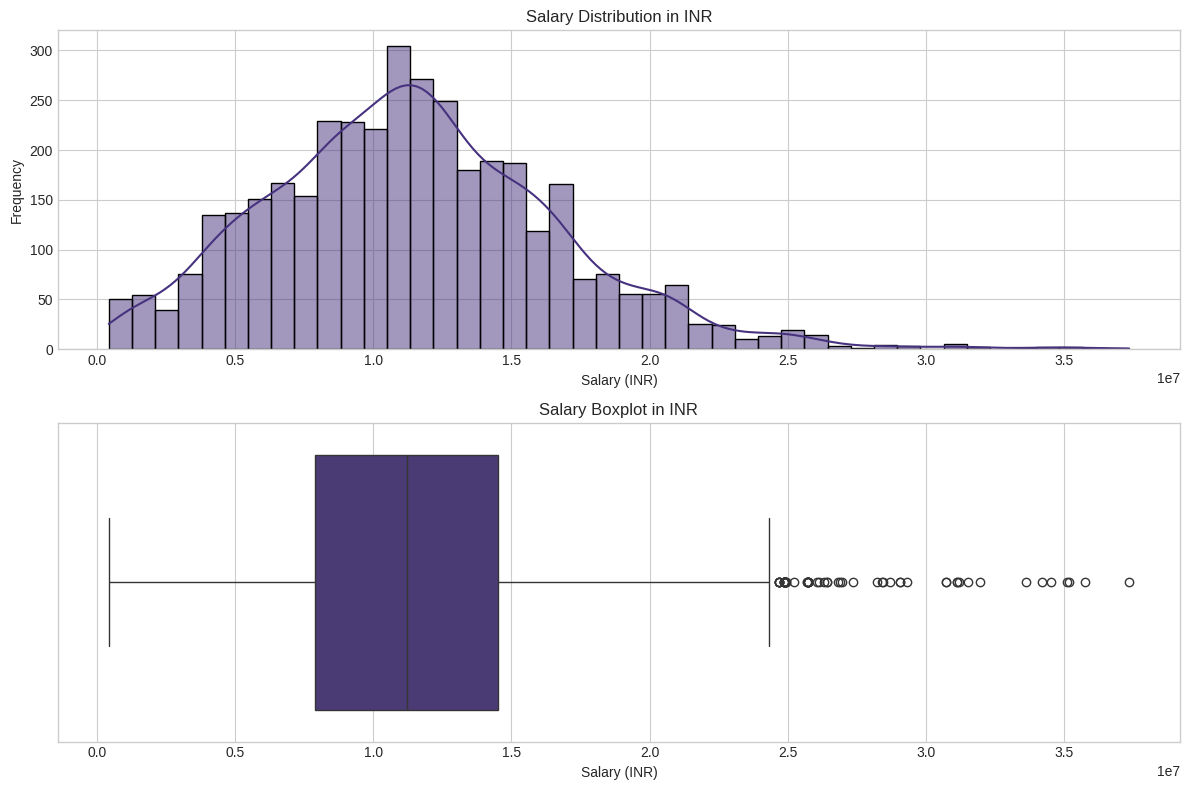

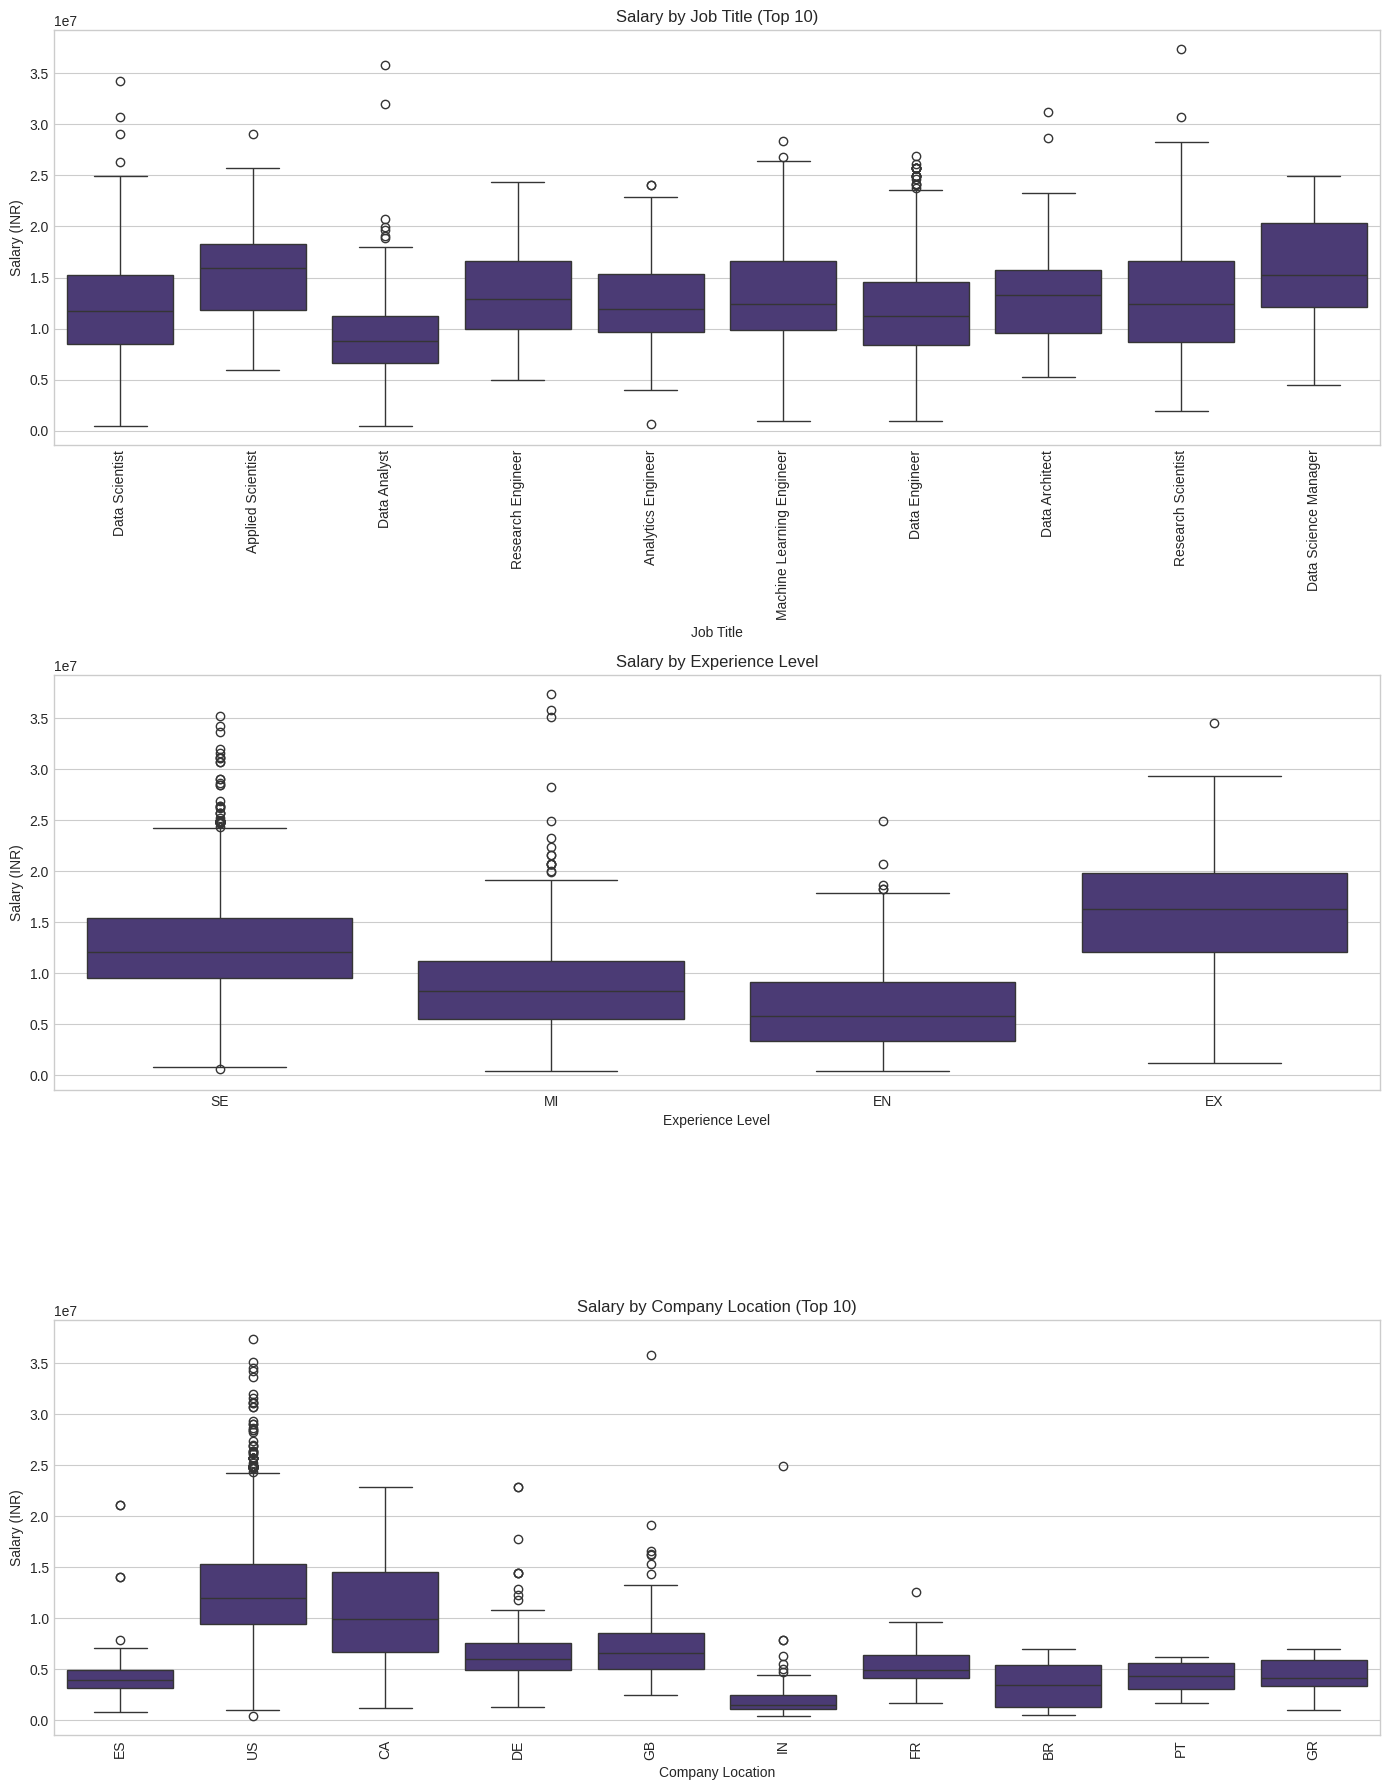

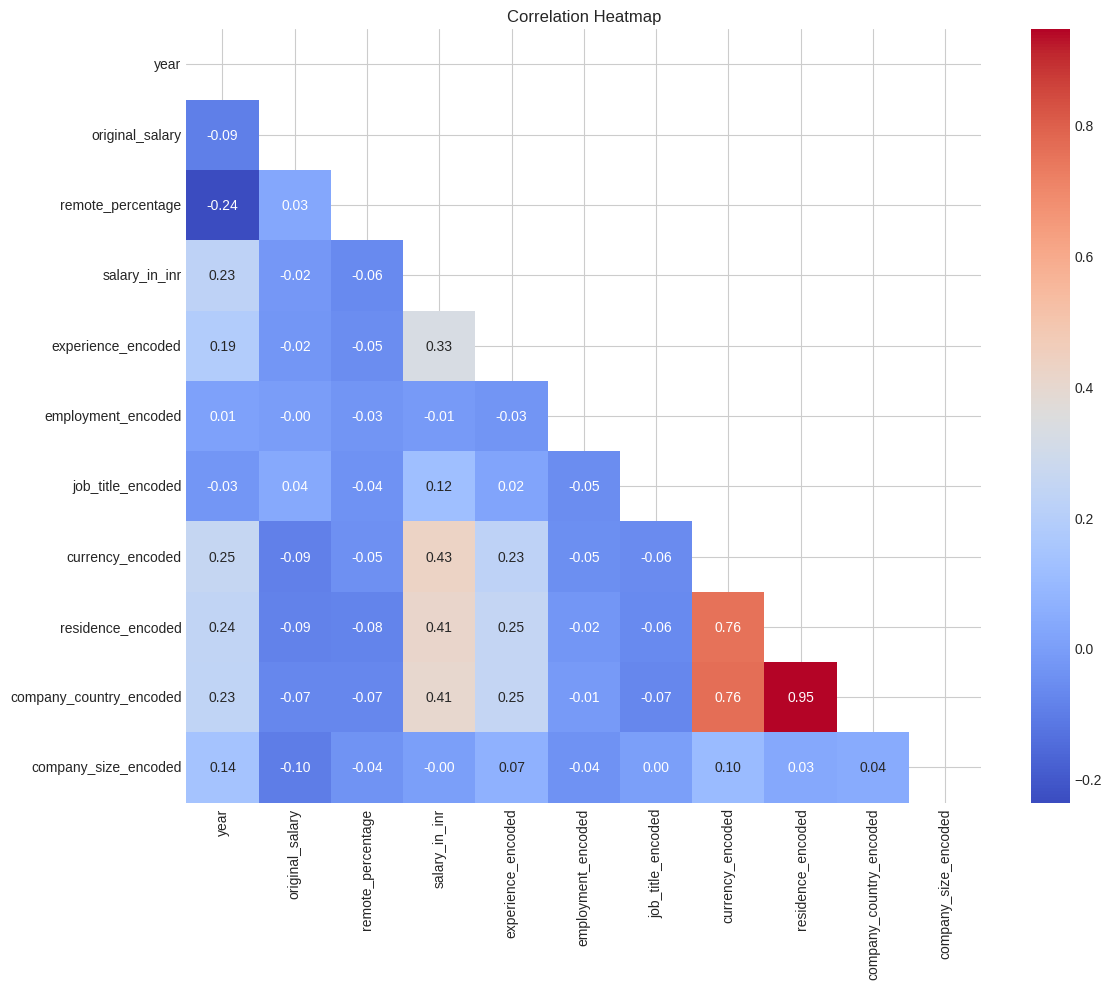

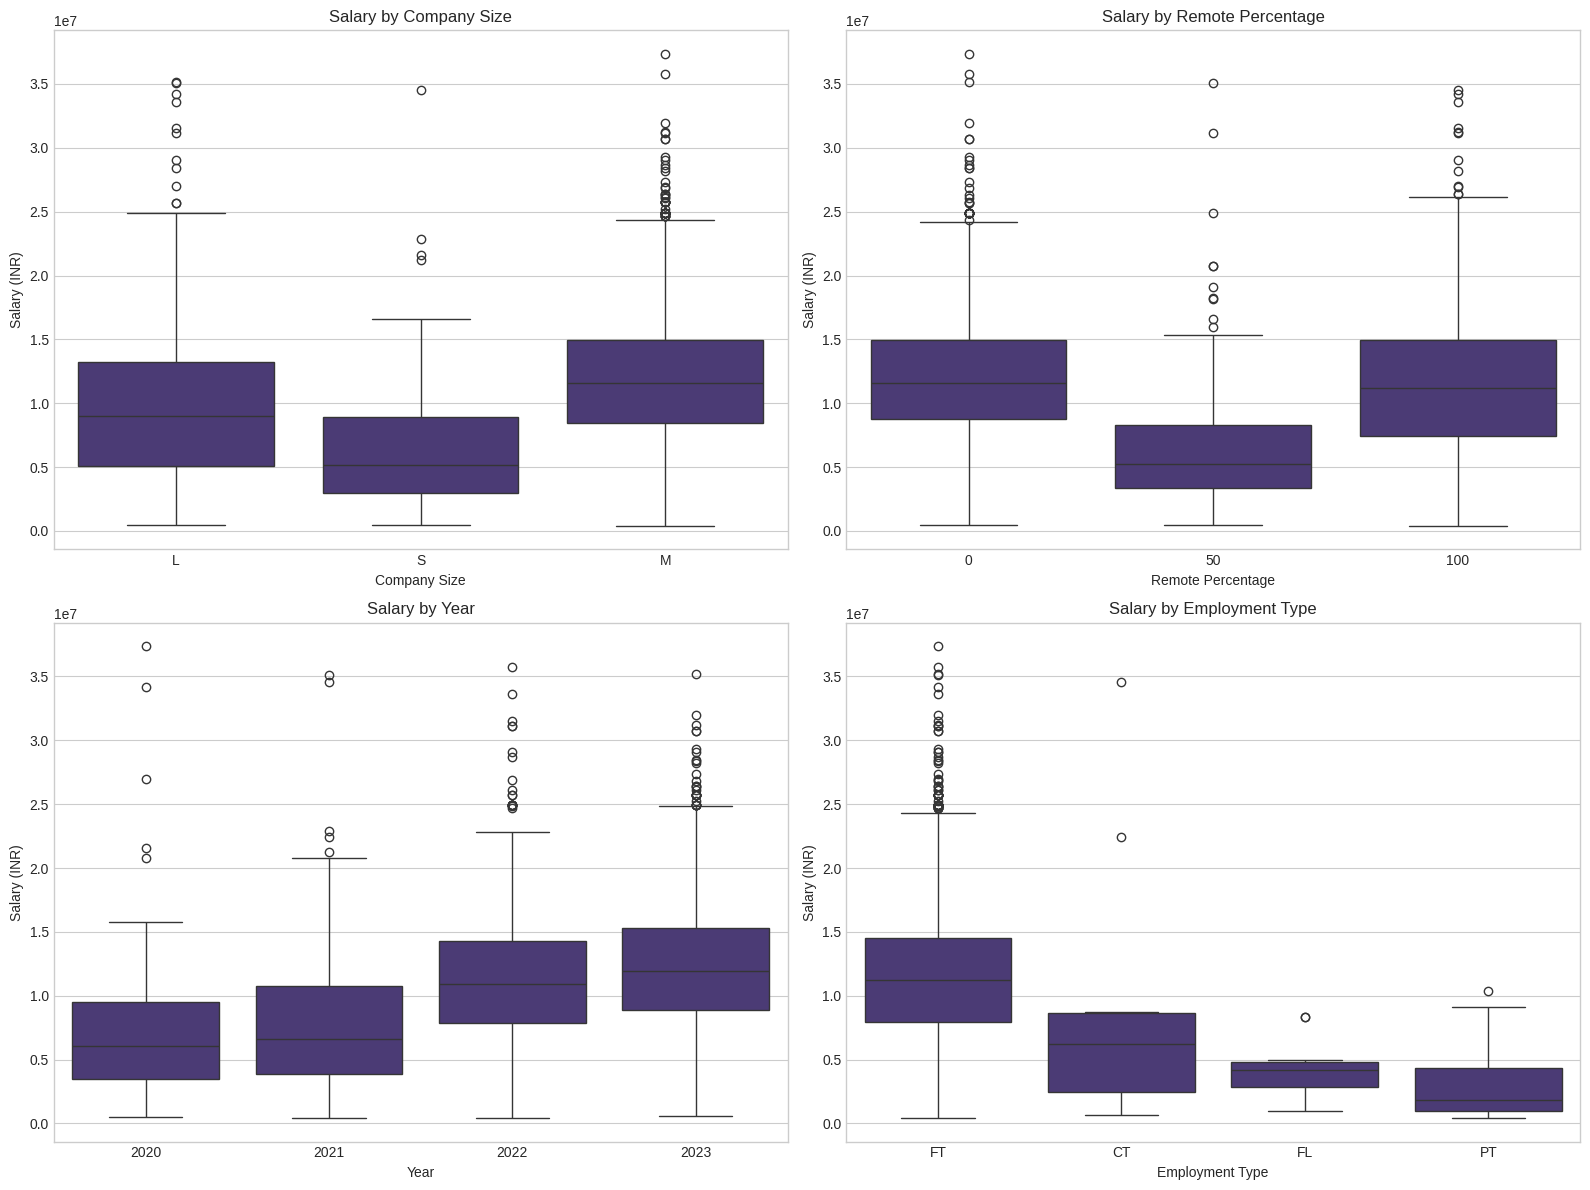



🤖 Training regression models...

Training Linear Regression...
  MAE: ₹₹34,08,495
  RMSE: ₹₹43,50,624
  R²: 0.3040

Training Decision Tree...
  MAE: ₹₹32,91,052
  RMSE: ₹₹44,15,989
  R²: 0.2830

Training Random Forest...
  MAE: ₹₹30,73,581
  RMSE: ₹₹40,82,458
  R²: 0.3872

Training XGBoost...
  MAE: ₹₹30,99,299
  RMSE: ₹₹41,47,982
  R²: 0.3673

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 8
[LightGBM] [Info] Start training from score 11458647.115846
  MAE: ₹₹30,35,853
  RMSE: ₹₹39,94,543
  R²: 0.4133

Training SVR...
  MAE: ₹₹40,30,427
  RMSE: ₹₹52,15,269
  R²: -0.0001

Training MLP Regressor...
  MAE: ₹₹39,70,381
  RMSE: ₹₹51,05,325
  R²: 0.0416


📈 Model Evaluatio

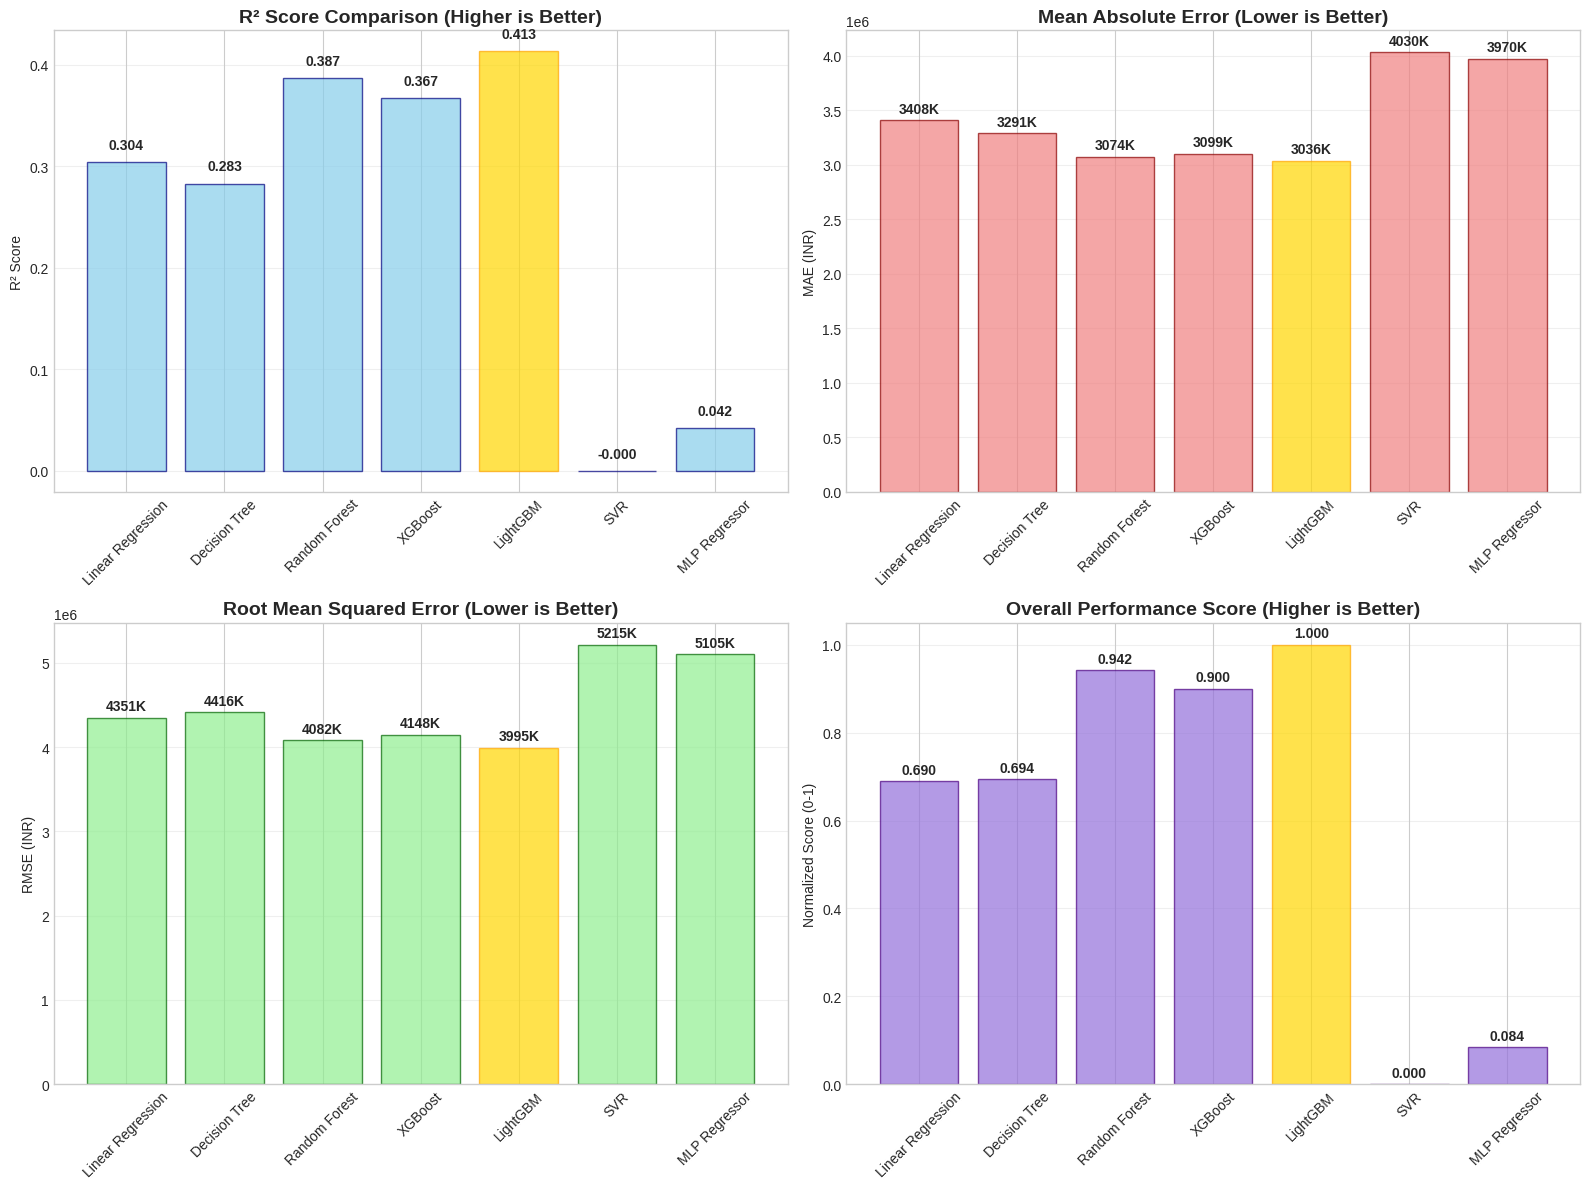


🏆 DETAILED MODEL PERFORMANCE RANKING:
            Model  R² Score  MAE (INR) RMSE (INR)  Overall Score  R² Rank  MAE Rank  RMSE Rank  Overall Rank
         LightGBM  0.413289 ₹30,35,853 ₹39,94,543       1.000000        1         1          1             1
    Random Forest  0.387179 ₹30,73,581 ₹40,82,458       0.942296        2         2          2             2
          XGBoost  0.367350 ₹30,99,299 ₹41,47,982       0.899795        3         3          3             3
    Decision Tree  0.282956 ₹32,91,052 ₹44,15,989       0.694296        5         4          5             4
Linear Regression  0.304026 ₹34,08,495 ₹43,50,624       0.689773        4         5          4             5
    MLP Regressor  0.041622 ₹39,70,381 ₹51,05,325       0.083789        6         6          6             6
              SVR -0.000100 ₹40,30,427 ₹52,15,269       0.000000        7         7          7             7

🥇 WINNER: LightGBM
   R² Score: 0.4133
   MAE: ₹30,35,853
   RMSE: ₹39,94,543
   Overall

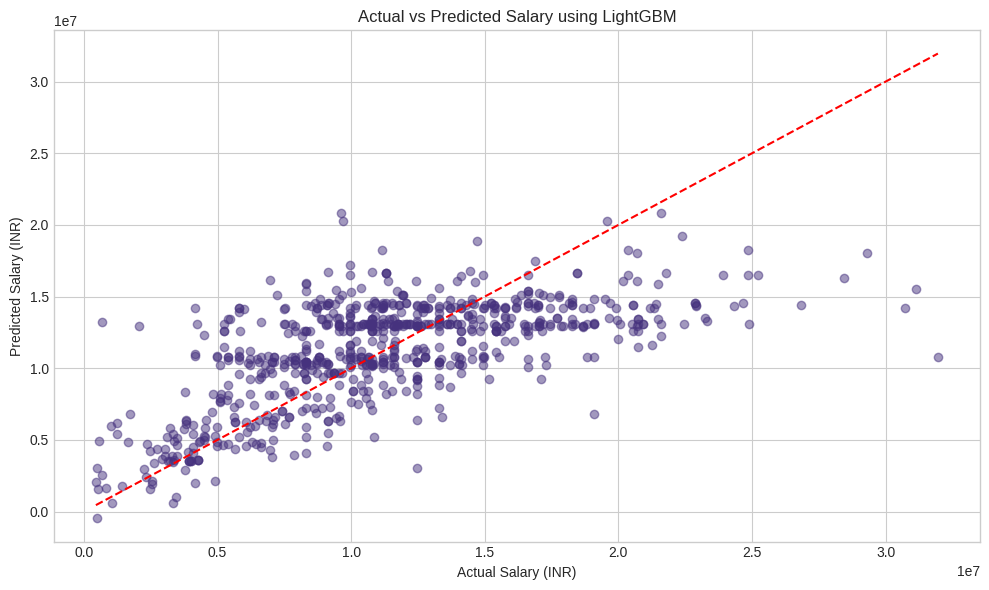



🏆 Best Model: LightGBM with R² score of 0.4133
Model saved as 'salary_model.pkl'


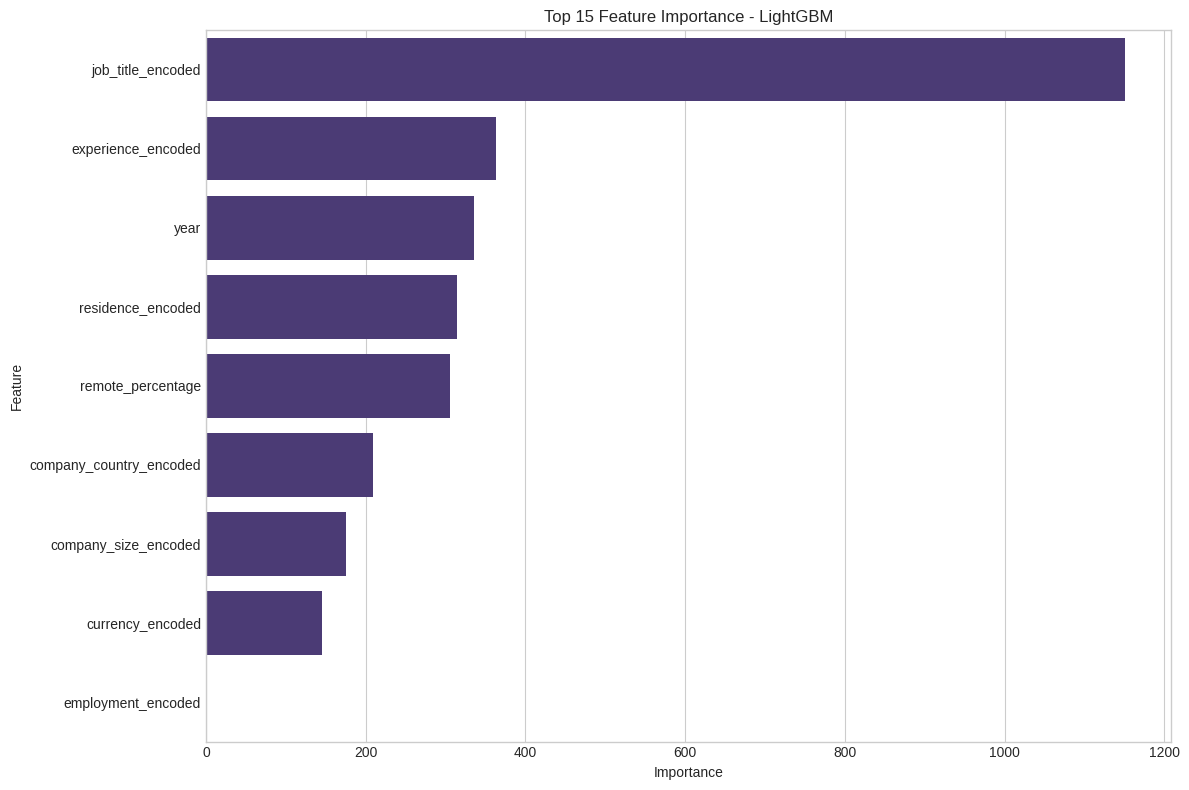


Top 10 most important features:
                   Feature  Importance
4        job_title_encoded        1151
2       experience_encoded         363
0                     year         336
6        residence_encoded         315
1        remote_percentage         306
7  company_country_encoded         209
8     company_size_encoded         175
5         currency_encoded         145
3       employment_encoded           0

✅ Summary Statistics of Salaries (INR):
Mean Salary: ₹1,14,18,342
Median Salary: ₹1,12,05,000
Min Salary: ₹4,25,956
Max Salary: ₹3,73,50,000
25th Percentile: ₹78,85,000
75th Percentile: ₹1,45,25,000


🎯 INTERACTIVE SALARY PREDICTION

💰 SALARY PREDICTION - Enter Your Details

📅 Available work years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Enter work year (e.g., 2023): 2023

🎯 Available experience levels:
  1. SE
  2. MI
  3. EN
  4. EX
Select experience level (1-4): 4

💼 Available employment types:
  1. FT
  2. CT
  3. FL
  4. PT
Select employmen

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
import locale
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Function to format currency in Indian format (e.g., ₹12,50,000)
def format_inr(amount):
    if pd.isna(amount):
        return "₹0"

    amount = float(amount)
    if amount == 0:
        return "₹0"

    s = str(int(amount))
    result = s[-3:]
    s = s[:-3]

    while s:
        result = s[-2:] + ',' + result if len(s) >= 2 else s + ',' + result
        s = s[:-2]

    return f"₹{result}"

# Function to get user input for salary prediction
def get_user_input(df, label_encoders):
    print("\n" + "="*60)
    print("💰 SALARY PREDICTION - Enter Your Details")
    print("="*60)

    user_data = {}

    # Work Year
    print(f"\n📅 Available work years: {sorted(df['year'].unique())}")
    while True:
        try:
            year = int(input("Enter work year (e.g., 2023): "))
            if year in df['year'].unique():
                user_data['year'] = year
                break
            else:
                print(f"Please enter a valid year from: {sorted(df['year'].unique())}")
        except ValueError:
            print("Please enter a valid number for year.")

    # Experience Level
    print(f"\n🎯 Available experience levels:")
    exp_options = df['experience'].unique()
    exp_descriptions = {
        'EN': 'Entry Level (EN) - 0-2 years of experience',
        'MI': 'Mid Level (MI) - 2-5 years of experience',
        'SE': 'Senior Level (SE) - 5-10 years of experience',
        'EX': 'Executive Level (EX) - 10+ years of experience'
    }

    for i, exp in enumerate(exp_options, 1):
        description = exp_descriptions.get(exp, f'{exp} - Experience Level')
        print(f"  {i}. {description}")

    while True:
        try:
            exp_choice = int(input(f"Select experience level (1-{len(exp_options)}): ")) - 1
            if 0 <= exp_choice < len(exp_options):
                experience = exp_options[exp_choice]
                user_data['experience'] = experience
                user_data['experience_encoded'] = label_encoders['experience'].transform([experience])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(exp_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Employment Type
    print(f"\n💼 Available employment types:")
    emp_options = df['employment'].unique()
    emp_descriptions = {
        'FT': 'Full Time (FT) - Standard 40+ hours per week employment',
        'PT': 'Part Time (PT) - Less than 40 hours per week employment',
        'CT': 'Contract (CT) - Fixed-term contract employment',
        'FL': 'Freelance (FL) - Independent contractor/consultant'
    }

    for i, emp in enumerate(emp_options, 1):
        description = emp_descriptions.get(emp, f'{emp} - Employment Type')
        print(f"  {i}. {description}")

    while True:
        try:
            emp_choice = int(input(f"Select employment type (1-{len(emp_options)}): ")) - 1
            if 0 <= emp_choice < len(emp_options):
                employment = emp_options[emp_choice]
                user_data['employment'] = employment
                user_data['employment_encoded'] = label_encoders['employment'].transform([employment])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(emp_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Job Title
    print(f"\n🚀 Available job titles (showing top 20 most common):")
    job_options = df['job_title'].value_counts().head(20).index.tolist()
    for i, job in enumerate(job_options, 1):
        print(f"  {i}. {job}")

    while True:
        try:
            job_choice = int(input(f"Select job title (1-{len(job_options)}): ")) - 1
            if 0 <= job_choice < len(job_options):
                job_title = job_options[job_choice]
                user_data['job_title'] = job_title
                user_data['job_title_encoded'] = label_encoders['job_title'].transform([job_title])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(job_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Company Size
    print(f"\n🏢 Available company sizes:")
    size_options = df['company_size'].unique()
    size_descriptions = {
        'S': 'Small (S) - Less than 50 employees',
        'M': 'Medium (M) - 50-250 employees',
        'L': 'Large (L) - More than 250 employees'
    }

    for i, size in enumerate(size_options, 1):
        description = size_descriptions.get(size, f'{size} - Company Size')
        print(f"  {i}. {description}")

    while True:
        try:
            size_choice = int(input(f"Select company size (1-{len(size_options)}): ")) - 1
            if 0 <= size_choice < len(size_options):
                company_size = size_options[size_choice]
                user_data['company_size'] = company_size
                user_data['company_size_encoded'] = label_encoders['company_size'].transform([company_size])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(size_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Remote Percentage
    print(f"\n🏠 Available remote work percentages: {sorted(df['remote_percentage'].unique())}")
    while True:
        try:
            remote = int(input("Enter remote work percentage (0, 50, or 100): "))
            if remote in df['remote_percentage'].unique():
                user_data['remote_percentage'] = remote
                break
            else:
                print(f"Please enter a valid remote percentage from: {sorted(df['remote_percentage'].unique())}")
        except ValueError:
            print("Please enter a valid number.")

    # Company Country
    print(f"\n🌍 Available company countries (showing top 15 most common):")
    country_options = df['company_country'].value_counts().head(15).index.tolist()
    for i, country in enumerate(country_options, 1):
        print(f"  {i}. {country}")

    while True:
        try:
            country_choice = int(input(f"Select company country (1-{len(country_options)}): ")) - 1
            if 0 <= country_choice < len(country_options):
                company_country = country_options[country_choice]
                user_data['company_country'] = company_country
                user_data['company_country_encoded'] = label_encoders['company_country'].transform([company_country])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(country_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Employee Residence
    print(f"\n🏡 Available employee residence countries (showing top 15 most common):")
    residence_options = df['residence'].value_counts().head(15).index.tolist()
    for i, residence in enumerate(residence_options, 1):
        print(f"  {i}. {residence}")

    while True:
        try:
            residence_choice = int(input(f"Select employee residence (1-{len(residence_options)}): ")) - 1
            if 0 <= residence_choice < len(residence_options):
                residence = residence_options[residence_choice]
                user_data['residence'] = residence
                user_data['residence_encoded'] = label_encoders['residence'].transform([residence])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(residence_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Currency (most common ones)
    print(f"\n💱 Available salary currencies:")
    currency_options = df['currency'].unique()
    for i, currency in enumerate(currency_options, 1):
        print(f"  {i}. {currency}")

    while True:
        try:
            currency_choice = int(input(f"Select salary currency (1-{len(currency_options)}): ")) - 1
            if 0 <= currency_choice < len(currency_options):
                currency = currency_options[currency_choice]
                user_data['currency'] = currency
                user_data['currency_encoded'] = label_encoders['currency'].transform([currency])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(currency_options)}")
        except ValueError:
            print("Please enter a valid number.")

    return user_data

# Function to prepare user input for prediction
def prepare_user_input_for_prediction(user_data, X_columns, df):
    # Create a dataframe with user input
    user_df = pd.DataFrame([user_data])

    # Create the same structure as training data
    prediction_input = pd.DataFrame(columns=X_columns, index=[0])
    prediction_input = prediction_input.fillna(0)

    # Fill in the encoded values
    prediction_input.loc[0, 'year'] = user_data['year']
    prediction_input.loc[0, 'experience_encoded'] = user_data['experience_encoded']
    prediction_input.loc[0, 'employment_encoded'] = user_data['employment_encoded']
    prediction_input.loc[0, 'job_title_encoded'] = user_data['job_title_encoded']
    prediction_input.loc[0, 'currency_encoded'] = user_data['currency_encoded']
    prediction_input.loc[0, 'residence_encoded'] = user_data['residence_encoded']
    prediction_input.loc[0, 'remote_percentage'] = user_data['remote_percentage']
    prediction_input.loc[0, 'company_country_encoded'] = user_data['company_country_encoded']
    prediction_input.loc[0, 'company_size_encoded'] = user_data['company_size_encoded']

    # Handle job title one-hot encoding
    job_column = f"job_{user_data['job_title']}"
    if job_column in X_columns:
        prediction_input.loc[0, job_column] = 1

    return prediction_input

# 1. Data Preprocessing
print("🔄 Loading and preprocessing data...")

# Load the dataset
url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/ds_salaries%20%281%29-uBxgrOMw5QFQp6IU9ErTKutI70vMvV.csv"
df = pd.read_csv(url)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Convert salary_in_usd to salary_in_inr (1 USD = 83 INR)
df['salary_in_inr'] = df['salary_in_usd'].astype(float) * 83

# Drop the USD salary column
df.drop('salary_in_usd', axis=1, inplace=True)

# Rename columns for clarity
df = df.rename(columns={
    'work_year': 'year',
    'experience_level': 'experience',
    'employment_type': 'employment',
    'job_title': 'job_title',
    'salary': 'original_salary',
    'salary_currency': 'currency',
    'employee_residence': 'residence',
    'remote_ratio': 'remote_percentage',
    'company_location': 'company_country',
    'company_size': 'company_size'
})

# Display the renamed columns
print("\nRenamed columns:")
print(df.columns.tolist())

# Encode categorical variables
categorical_columns = ['experience', 'employment', 'job_title', 'currency',
                      'residence', 'company_country', 'company_size']

# Create a dictionary to store the label encoders
label_encoders = {}

# Apply label encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

    # Print mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\nEncoding for {col}:")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")

# Create dummy variables for job titles (one-hot encoding)
job_dummies = pd.get_dummies(df['job_title'], prefix='job')
df = pd.concat([df, job_dummies], axis=1)

# 2. Exploratory Data Analysis (EDA)
print("\n\n📊 Performing Exploratory Data Analysis...")

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure for the salary distribution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.histplot(df['salary_in_inr'], kde=True)
plt.title('Salary Distribution in INR')
plt.xlabel('Salary (INR)')
plt.ylabel('Frequency')

# Add a boxplot for the salary distribution
plt.subplot(2, 1, 2)
sns.boxplot(x=df['salary_in_inr'])
plt.title('Salary Boxplot in INR')
plt.xlabel('Salary (INR)')
plt.tight_layout()
plt.show()

# Create boxplots for categorical variables vs salary
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Top 10 job titles by frequency
top_jobs = df['job_title'].value_counts().head(10).index
job_salary_data = df[df['job_title'].isin(top_jobs)]

sns.boxplot(x='job_title', y='salary_in_inr', data=job_salary_data, ax=axes[0])
axes[0].set_title('Salary by Job Title (Top 10)')
axes[0].set_xlabel('Job Title')
axes[0].set_ylabel('Salary (INR)')
axes[0].tick_params(axis='x', rotation=90)

# Experience vs Salary
sns.boxplot(x='experience', y='salary_in_inr', data=df, ax=axes[1])
axes[1].set_title('Salary by Experience Level')
axes[1].set_xlabel('Experience Level')
axes[1].set_ylabel('Salary (INR)')

# Top 10 company locations by frequency
top_locations = df['company_country'].value_counts().head(10).index
location_salary_data = df[df['company_country'].isin(top_locations)]

sns.boxplot(x='company_country', y='salary_in_inr', data=location_salary_data, ax=axes[2])
axes[2].set_title('Salary by Company Location (Top 10)')
axes[2].set_xlabel('Company Location')
axes[2].set_ylabel('Salary (INR)')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Create correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Additional plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Salary by company size
sns.boxplot(x='company_size', y='salary_in_inr', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Salary by Company Size')
axes[0, 0].set_xlabel('Company Size')
axes[0, 0].set_ylabel('Salary (INR)')

# Salary by remote ratio
sns.boxplot(x='remote_percentage', y='salary_in_inr', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Salary by Remote Percentage')
axes[0, 1].set_xlabel('Remote Percentage')
axes[0, 1].set_ylabel('Salary (INR)')

# Salary by work year
sns.boxplot(x='year', y='salary_in_inr', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Salary by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Salary (INR)')

# Salary by employment type
sns.boxplot(x='employment', y='salary_in_inr', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Salary by Employment Type')
axes[1, 1].set_xlabel('Employment Type')
axes[1, 1].set_ylabel('Salary (INR)')

plt.tight_layout()
plt.show()

# 3. Model Training
print("\n\n🤖 Training regression models...")

# Prepare the data for modeling
X = df.select_dtypes(include=[np.number])
X = X.drop(['salary_in_inr', 'original_salary'], axis=1, errors='ignore')
y = df['salary_in_inr']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'model': model
    }

    print(f"  MAE: ₹{format_inr(mae)}")
    print(f"  RMSE: ₹{format_inr(rmse)}")
    print(f"  R²: {r2:.4f}")

    # Check if this is the best model so far
    if r2 > best_score:
        best_score = r2
        best_model = name

# 4. Model Evaluation
print("\n\n📈 Model Evaluation Results:")
print("\nModel comparison:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'R²': [results[model]['R²'] for model in results]
})
comparison_df = comparison_df.sort_values('R²', ascending=False)
print(comparison_df)

# Format the MAE and RMSE columns in INR format
comparison_df['MAE (INR)'] = comparison_df['MAE'].apply(format_inr)
comparison_df['RMSE (INR)'] = comparison_df['RMSE'].apply(format_inr)
comparison_df = comparison_df.drop(['MAE', 'RMSE'], axis=1)

# Create comprehensive model comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score comparison (higher is better)
r2_scores = [results[model]['R²'] for model in results]
model_names = list(results.keys())

bars1 = axes[0, 0].bar(model_names, r2_scores, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_title('R² Score Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars1, r2_scores):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best model
best_idx = r2_scores.index(max(r2_scores))
bars1[best_idx].set_color('gold')
bars1[best_idx].set_edgecolor('orange')

# 2. MAE comparison (lower is better)
mae_scores = [results[model]['MAE'] for model in results]
bars2 = axes[0, 1].bar(model_names, mae_scores, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[0, 1].set_title('Mean Absolute Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MAE (INR)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mae in zip(bars2, mae_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + max(mae_scores)*0.01,
                    f'{mae/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest MAE)
best_mae_idx = mae_scores.index(min(mae_scores))
bars2[best_mae_idx].set_color('gold')
bars2[best_mae_idx].set_edgecolor('orange')

# 3. RMSE comparison (lower is better)
rmse_scores = [results[model]['RMSE'] for model in results]
bars3 = axes[1, 0].bar(model_names, rmse_scores, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[1, 0].set_title('Root Mean Squared Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('RMSE (INR)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rmse in zip(bars3, rmse_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(rmse_scores)*0.01,
                    f'{rmse/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest RMSE)
best_rmse_idx = rmse_scores.index(min(rmse_scores))
bars3[best_rmse_idx].set_color('gold')
bars3[best_rmse_idx].set_edgecolor('orange')

# 4. Combined performance radar chart style comparison
# Normalize scores for better comparison (0-1 scale)
normalized_r2 = [(score - min(r2_scores)) / (max(r2_scores) - min(r2_scores)) for score in r2_scores]
normalized_mae = [1 - (score - min(mae_scores)) / (max(mae_scores) - min(mae_scores)) for score in mae_scores]  # Inverted because lower is better
normalized_rmse = [1 - (score - min(rmse_scores)) / (max(rmse_scores) - min(rmse_scores)) for score in rmse_scores]  # Inverted because lower is better

# Calculate overall performance score
overall_scores = [(r2 + mae + rmse) / 3 for r2, mae, rmse in zip(normalized_r2, normalized_mae, normalized_rmse)]

bars4 = axes[1, 1].bar(model_names, overall_scores, color='mediumpurple', edgecolor='indigo', alpha=0.7)
axes[1, 1].set_title('Overall Performance Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Normalized Score (0-1)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars4, overall_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best overall model
best_overall_idx = overall_scores.index(max(overall_scores))
bars4[best_overall_idx].set_color('gold')
bars4[best_overall_idx].set_edgecolor('orange')

plt.tight_layout()
plt.show()

# Print detailed comparison table with rankings
print("\n🏆 DETAILED MODEL PERFORMANCE RANKING:")
print("=" * 80)

ranking_df = pd.DataFrame({
    'Model': model_names,
    'R² Score': r2_scores,
    'MAE (INR)': [format_inr(mae) for mae in mae_scores],
    'RMSE (INR)': [format_inr(rmse) for rmse in rmse_scores],
    'Overall Score': overall_scores
})

# Add rankings
ranking_df['R² Rank'] = ranking_df['R² Score'].rank(ascending=False).astype(int)
ranking_df['MAE Rank'] = pd.Series(mae_scores).rank(ascending=True).astype(int)
ranking_df['RMSE Rank'] = pd.Series(rmse_scores).rank(ascending=True).astype(int)
ranking_df['Overall Rank'] = ranking_df['Overall Score'].rank(ascending=False).astype(int)

# Sort by overall rank
ranking_df = ranking_df.sort_values('Overall Rank')

print(ranking_df.to_string(index=False))

# Highlight the winner
best_model_overall = ranking_df.iloc[0]['Model']
print(f"\n🥇 WINNER: {best_model_overall}")
print(f"   R² Score: {ranking_df.iloc[0]['R² Score']:.4f}")
print(f"   MAE: {ranking_df.iloc[0]['MAE (INR)']}")
print(f"   RMSE: {ranking_df.iloc[0]['RMSE (INR)']}")
print(f"   Overall Score: {ranking_df.iloc[0]['Overall Score']:.4f}")

# Plot actual vs predicted values for the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_obj = results[best_model_name]['model']

y_pred = best_model_obj.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary (INR)')
plt.ylabel('Predicted Salary (INR)')
plt.title(f'Actual vs Predicted Salary using {best_model_name}')
plt.tight_layout()
plt.show()

# 5. Save the best model
print(f"\n\n🏆 Best Model: {best_model_name} with R² score of {results[best_model_name]['R²']:.4f}")
joblib.dump(results[best_model_name]['model'], 'salary_model.pkl')
print("Model saved as 'salary_model.pkl'")

# Feature importance for the best model (if applicable)
if best_model_name in ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']:
    feature_importance = None

    if best_model_name == 'Decision Tree':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'Random Forest':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'XGBoost':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'LightGBM':
        feature_importance = results[best_model_name]['model'].feature_importances_

    if feature_importance is not None:
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
        plt.title(f'Top 15 Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.show()

        print("\nTop 10 most important features:")
        print(feature_importance_df.head(10))

# Summary statistics of salaries in INR
print("\n✅ Summary Statistics of Salaries (INR):")
salary_stats = df['salary_in_inr'].describe()
print(f"Mean Salary: {format_inr(salary_stats['mean'])}")
print(f"Median Salary: {format_inr(df['salary_in_inr'].median())}")
print(f"Min Salary: {format_inr(salary_stats['min'])}")
print(f"Max Salary: {format_inr(salary_stats['max'])}")
print(f"25th Percentile: {format_inr(salary_stats['25%'])}")
print(f"75th Percentile: {format_inr(salary_stats['75%'])}")

# 6. Interactive Salary Prediction
print("\n\n🎯 INTERACTIVE SALARY PREDICTION")
print("=" * 60)

while True:
    try:
        # Get user input
        user_data = get_user_input(df, label_encoders)

        # Prepare input for prediction
        prediction_input = prepare_user_input_for_prediction(user_data, X.columns, df)

        # Make predictions with all models
        print("\n" + "="*60)
        print("🔮 SALARY PREDICTIONS")
        print("="*60)

        predictions = {}
        for model_name, model_info in results.items():
            try:
                pred = model_info['model'].predict(prediction_input)[0]
                predictions[model_name] = pred
                print(f"{model_name:20}: {format_inr(pred)}")
            except Exception as e:
                print(f"{model_name:20}: Error - {str(e)}")

        # Show best model prediction prominently
        if best_model_name in predictions:
            best_prediction = predictions[best_model_name]
            print("\n" + "🏆" * 20)
            print(f"BEST MODEL PREDICTION ({best_model_name}):")
            print(f"Predicted Salary: {format_inr(best_prediction)}")
            print("🏆" * 20)

        # Show user's input summary with full descriptions
        print(f"\n📋 Your Input Summary:")
        print(f"   Work Year: {user_data['year']}")

        # Experience level with description
        exp_desc = {
            'EN': 'Entry Level (0-2 years experience)',
            'MI': 'Mid Level (2-5 years experience)',
            'SE': 'Senior Level (5-10 years experience)',
            'EX': 'Executive Level (10+ years experience)'
        }
        print(f"   Experience: {exp_desc.get(user_data['experience'], user_data['experience'])}")

        # Employment type with description
        emp_desc = {
            'FT': 'Full Time',
            'PT': 'Part Time',
            'CT': 'Contract',
            'FL': 'Freelance'
        }
        print(f"   Employment Type: {emp_desc.get(user_data['employment'], user_data['employment'])}")

        print(f"   Job Title: {user_data['job_title']}")

        # Company size with description
        size_desc = {
            'S': 'Small Company (Less than 50 employees)',
            'M': 'Medium Company (50-250 employees)',
            'L': 'Large Company (More than 250 employees)'
        }
        print(f"   Company Size: {size_desc.get(user_data['company_size'], user_data['company_size'])}")

        print(f"   Remote Work: {user_data['remote_percentage']}% (0% = On-site, 50% = Hybrid, 100% = Fully Remote)")
        print(f"   Company Country: {user_data['company_country']}")
        print(f"   Employee Residence: {user_data['residence']}")
        print(f"   Salary Currency: {user_data['currency']}")

        # Show salary range for similar profiles
        similar_profiles = df[
            (df['experience'] == user_data['experience']) &
            (df['job_title'] == user_data['job_title'])
        ]

        if len(similar_profiles) > 0:
            print(f"\n📊 Salary Range for Similar Profiles:")
            print(f"   Min: {format_inr(similar_profiles['salary_in_inr'].min())}")
            print(f"   Max: {format_inr(similar_profiles['salary_in_inr'].max())}")
            print(f"   Average: {format_inr(similar_profiles['salary_in_inr'].mean())}")
            print(f"   Median: {format_inr(similar_profiles['salary_in_inr'].median())}")
            print(f"   Sample Size: {len(similar_profiles)} profiles")

        # Ask if user wants to predict another salary
        print("\n" + "="*60)
        another = input("Would you like to predict another salary? (y/n): ").lower().strip()
        if another not in ['y', 'yes']:
            break

    except KeyboardInterrupt:
        print("\n\nExiting salary prediction...")
        break
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("Please try again.")

print("\nDone! All tasks completed successfully.")
print("Thank you for using the Data Science Salary Predictor! 🚀")


🔄 Loading and preprocessing data...
Dataset shape: (3755, 11)

First few rows of the dataset:
   work_year experience_level employment_type                 job_title  salary salary_currency  salary_in_usd employee_residence  remote_ratio company_location company_size
0       2023               SE              FT  Principal Data Scientist   80000             EUR          85847                 ES           100               ES            L
1       2023               MI              CT               ML Engineer   30000             USD          30000                 US           100               US            S
2       2023               MI              CT               ML Engineer   25500             USD          25500                 US           100               US            S
3       2023               SE              FT            Data Scientist  175000             USD         175000                 CA           100               CA            M
4       2023               SE       

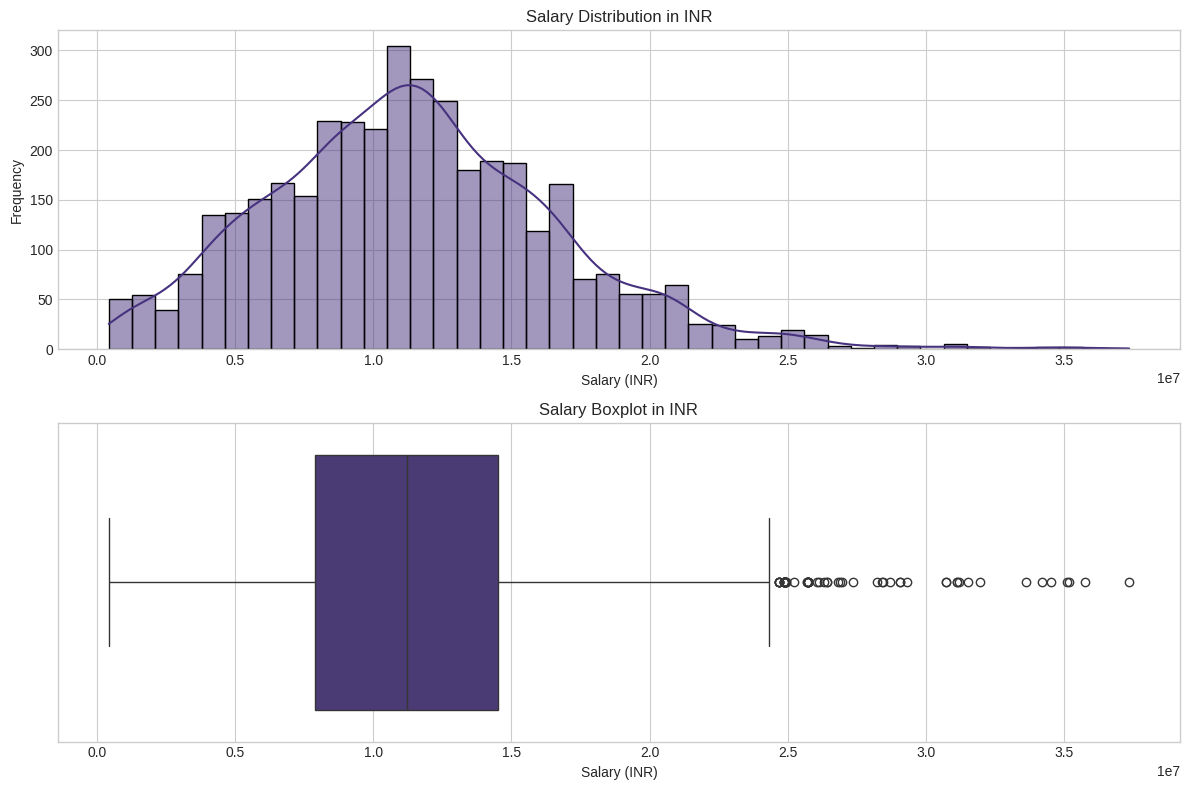

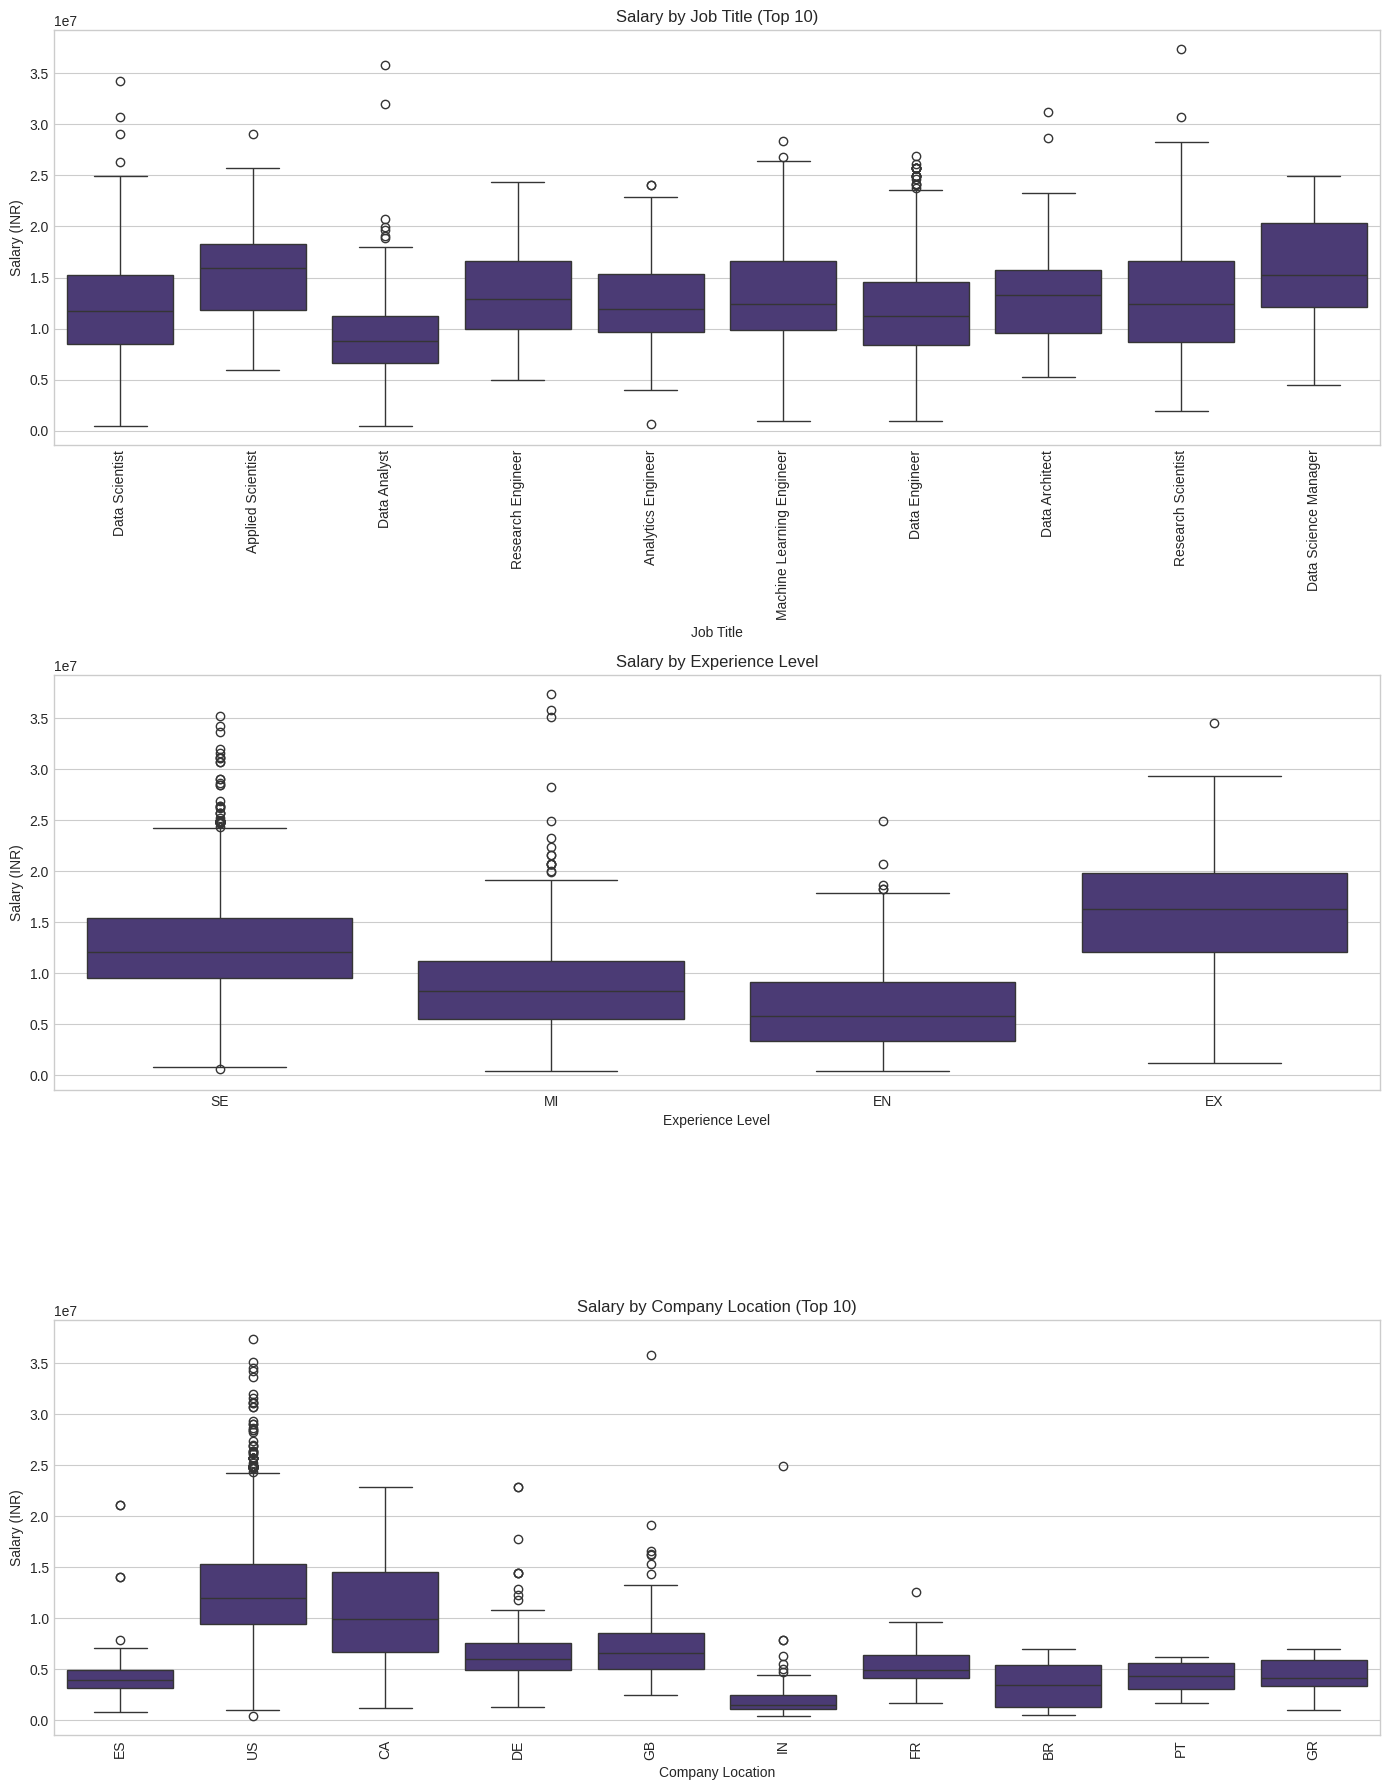

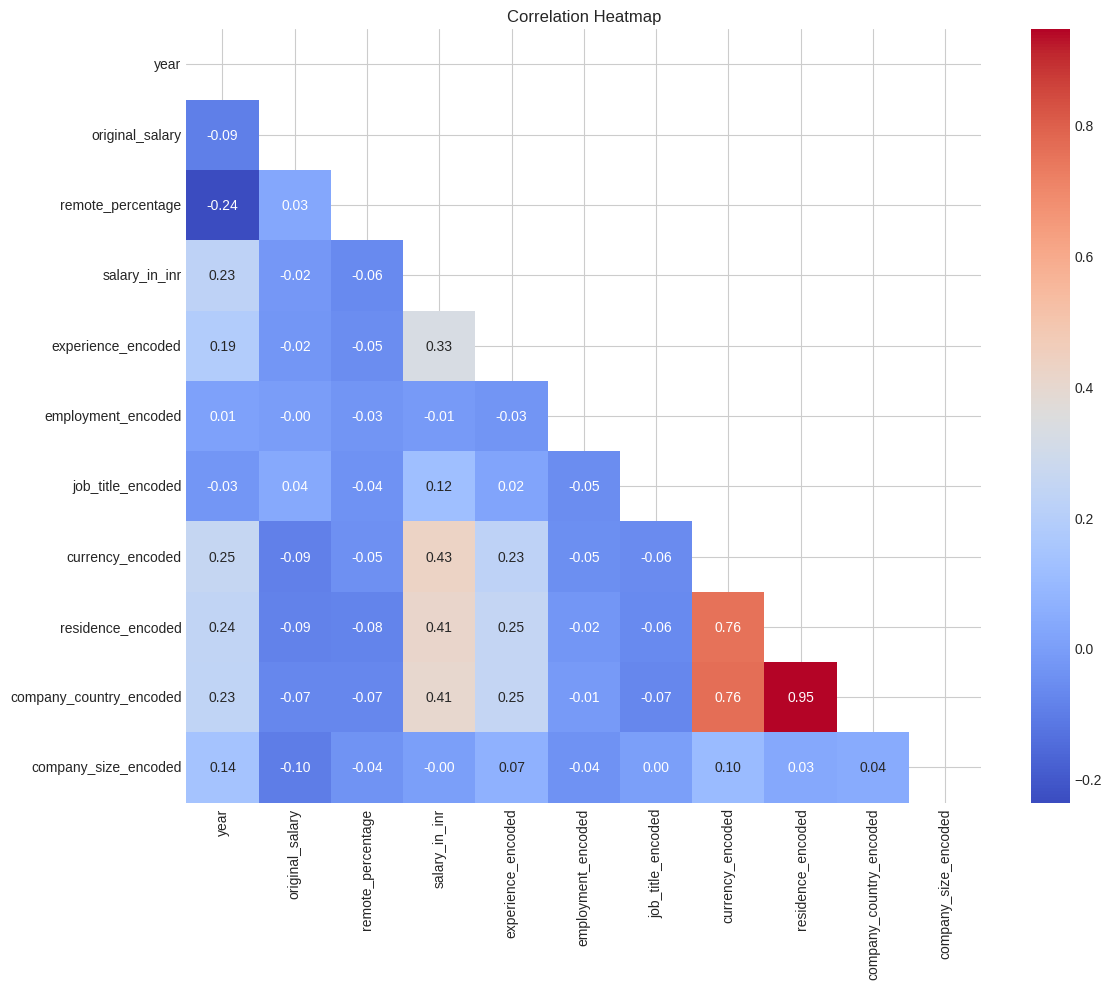

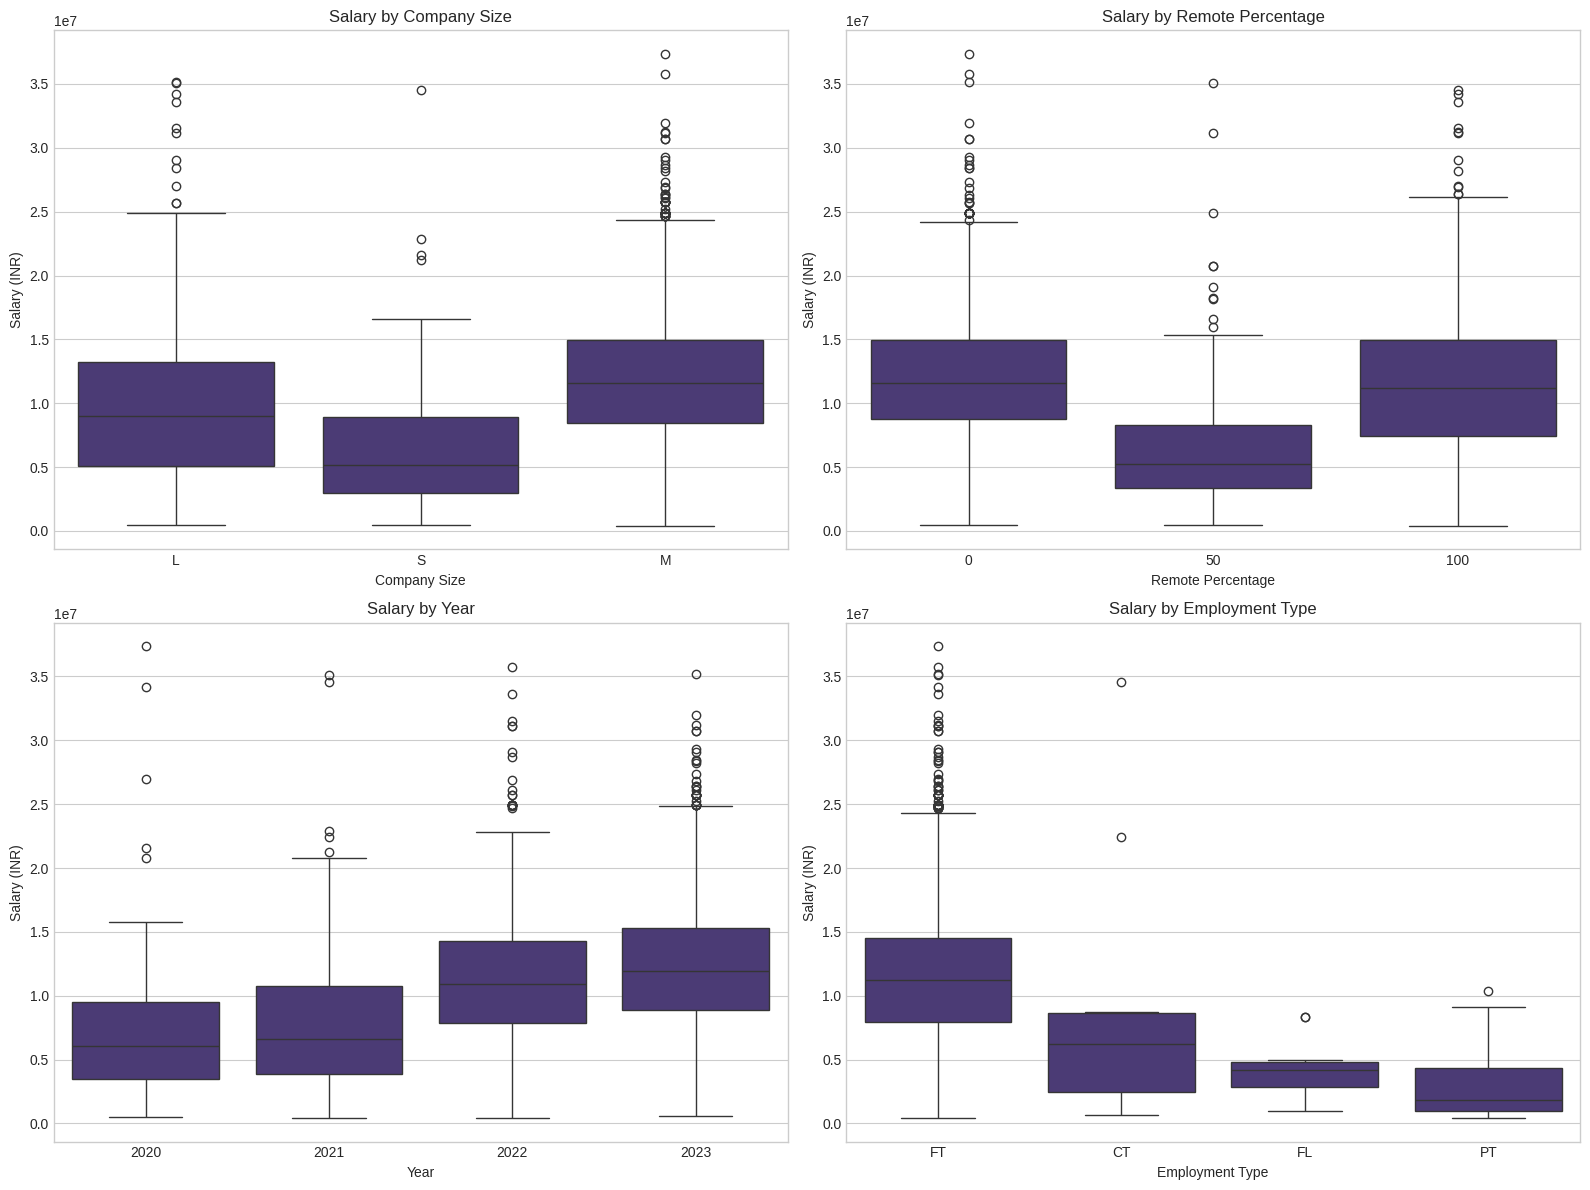



🤖 Training regression models...

Training Linear Regression...
  MAE: ₹₹34,08,495
  RMSE: ₹₹43,50,624
  R²: 0.3040

Training Decision Tree...
  MAE: ₹₹32,91,052
  RMSE: ₹₹44,15,989
  R²: 0.2830

Training Random Forest...
  MAE: ₹₹30,73,581
  RMSE: ₹₹40,82,458
  R²: 0.3872

Training XGBoost...
  MAE: ₹₹30,99,299
  RMSE: ₹₹41,47,982
  R²: 0.3673

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 8
[LightGBM] [Info] Start training from score 11458647.115846
  MAE: ₹₹30,35,853
  RMSE: ₹₹39,94,543
  R²: 0.4133

Training SVR...
  MAE: ₹₹40,30,427
  RMSE: ₹₹52,15,269
  R²: -0.0001

Training MLP Regressor...
  MAE: ₹₹39,70,381
  RMSE: ₹₹51,05,325
  R²: 0.0416


📈 Model Evaluatio

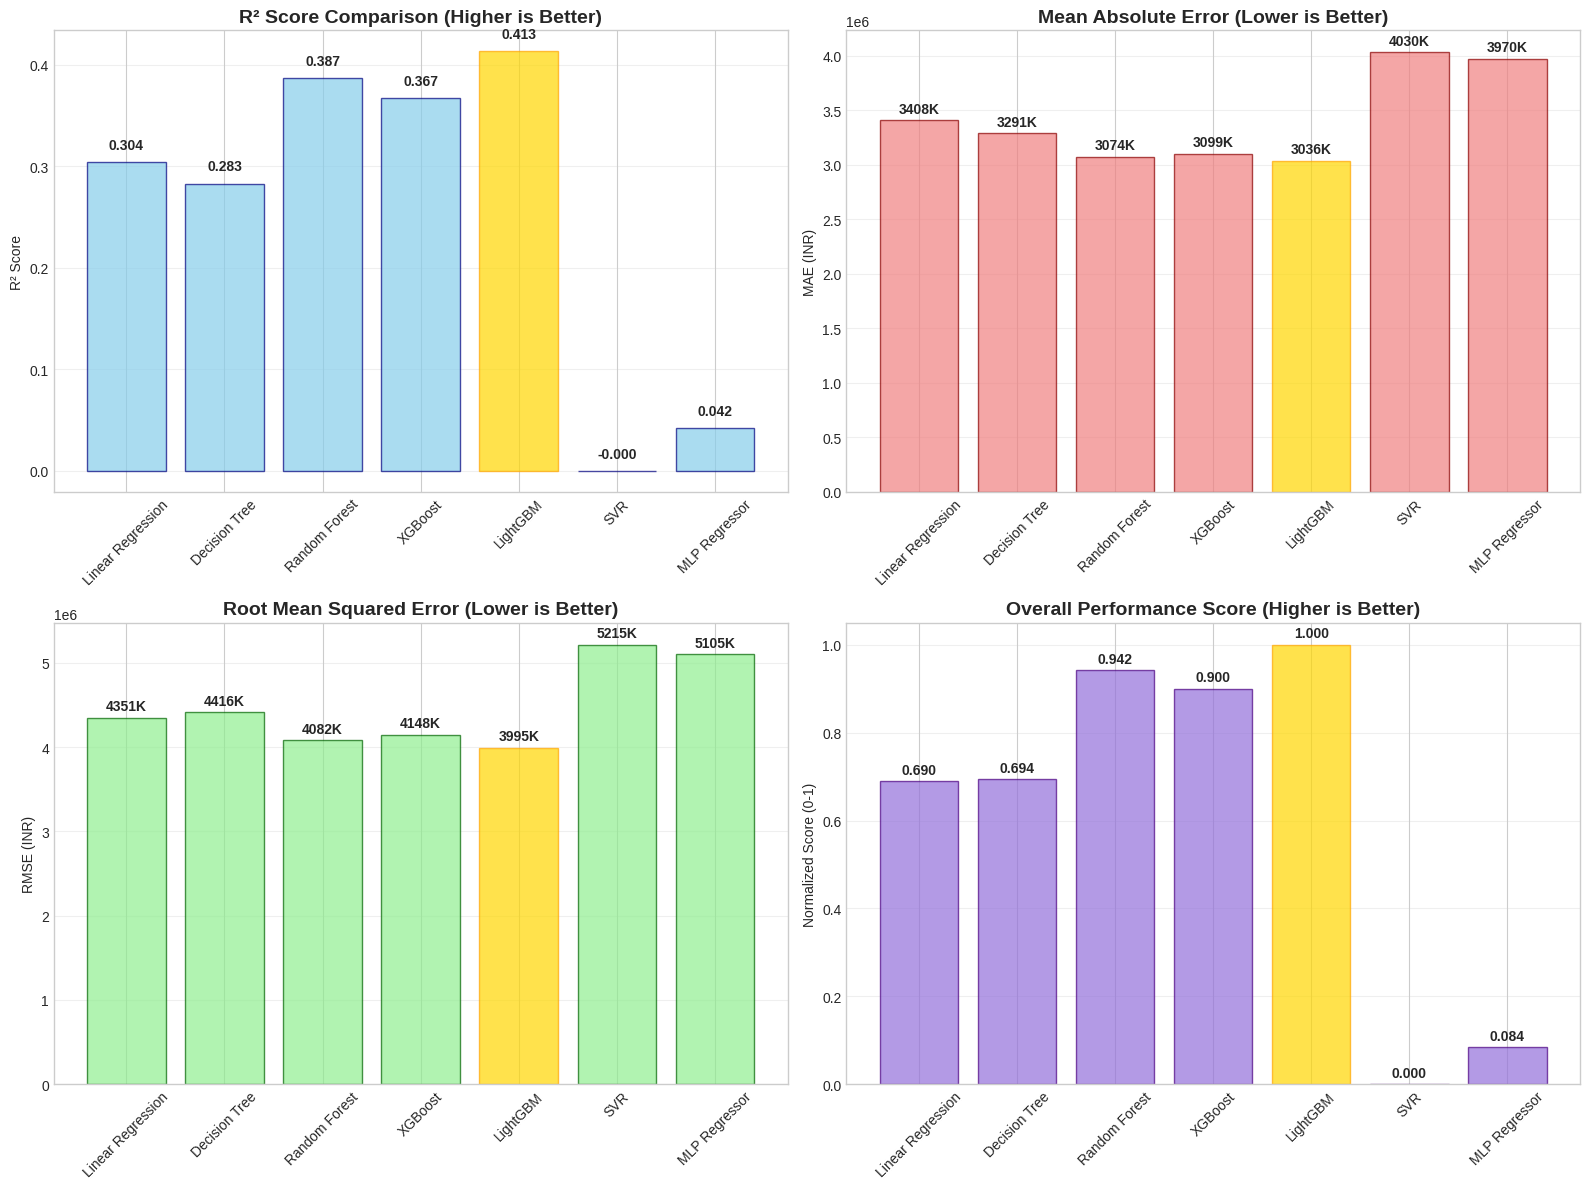


🏆 DETAILED MODEL PERFORMANCE RANKING:
            Model  R² Score  MAE (INR) RMSE (INR)  Overall Score  R² Rank  MAE Rank  RMSE Rank  Overall Rank
         LightGBM  0.413289 ₹30,35,853 ₹39,94,543       1.000000        1         1          1             1
    Random Forest  0.387179 ₹30,73,581 ₹40,82,458       0.942296        2         2          2             2
          XGBoost  0.367350 ₹30,99,299 ₹41,47,982       0.899795        3         3          3             3
    Decision Tree  0.282956 ₹32,91,052 ₹44,15,989       0.694296        5         4          5             4
Linear Regression  0.304026 ₹34,08,495 ₹43,50,624       0.689773        4         5          4             5
    MLP Regressor  0.041622 ₹39,70,381 ₹51,05,325       0.083789        6         6          6             6
              SVR -0.000100 ₹40,30,427 ₹52,15,269       0.000000        7         7          7             7

🥇 WINNER: LightGBM
   R² Score: 0.4133
   MAE: ₹30,35,853
   RMSE: ₹39,94,543
   Overall

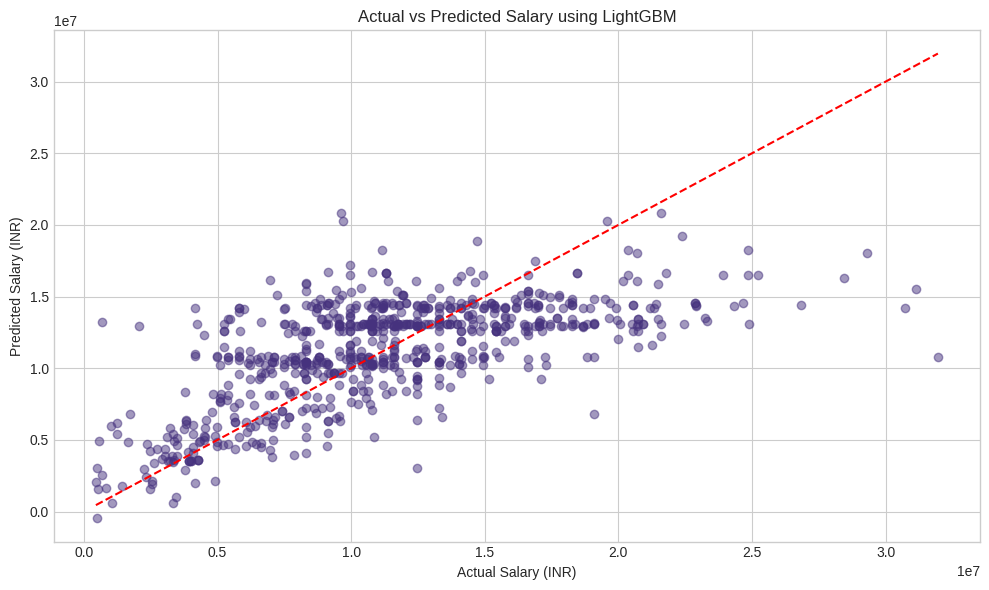



🏆 Best Model: LightGBM with R² score of 0.4133
Model saved as 'salary_model.pkl'


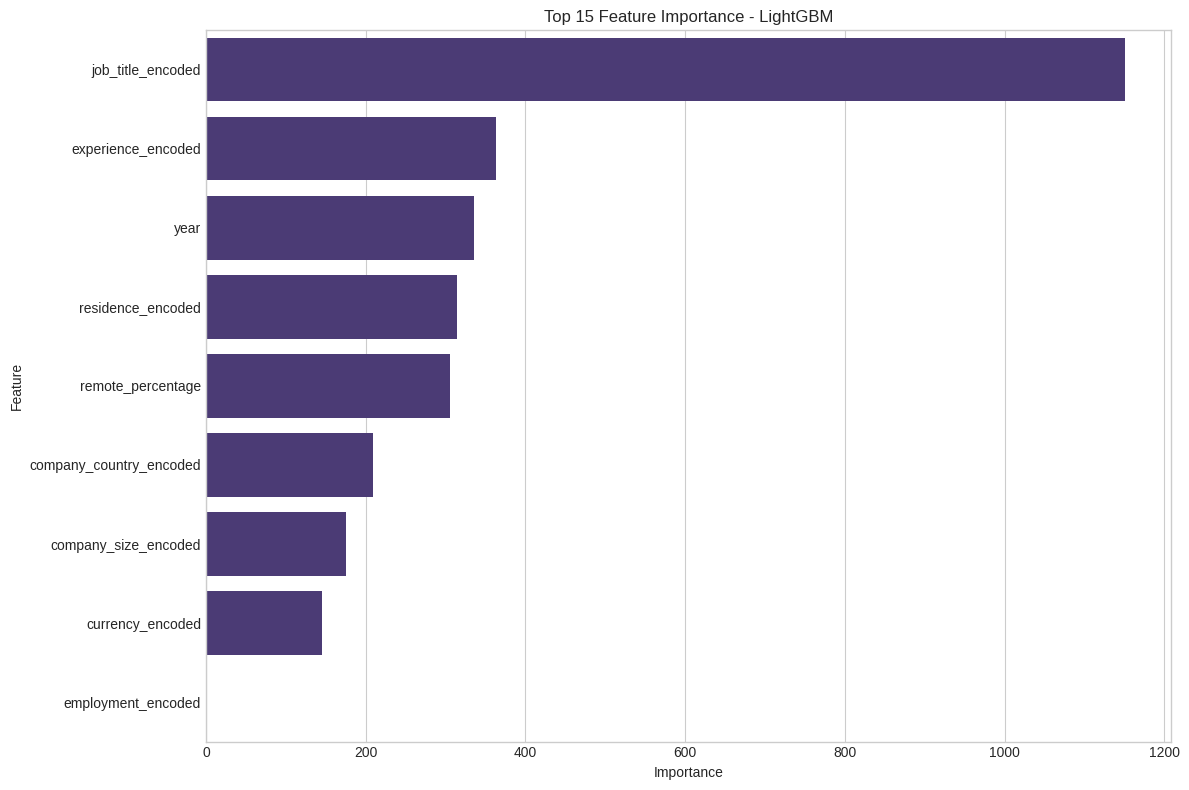


Top 10 most important features:
                   Feature  Importance
4        job_title_encoded        1151
2       experience_encoded         363
0                     year         336
6        residence_encoded         315
1        remote_percentage         306
7  company_country_encoded         209
8     company_size_encoded         175
5         currency_encoded         145
3       employment_encoded           0

✅ Summary Statistics of Salaries (INR):
Mean Salary: ₹1,14,18,342
Median Salary: ₹1,12,05,000
Min Salary: ₹4,25,956
Max Salary: ₹3,73,50,000
25th Percentile: ₹78,85,000
75th Percentile: ₹1,45,25,000


🎯 INTERACTIVE SALARY PREDICTION

💰 SALARY PREDICTION - Enter Your Details

📅 Available work years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Enter work year (e.g., 2023): 2020

🎯 Available experience levels:
  1. Senior Level (SE) - 5-10 years of experience
  2. Mid Level (MI) - 2-5 years of experience
  3. Entry Level (EN) - 0-2 years of experience


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
import locale
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Function to format currency in Indian format (e.g., ₹12,50,000)
def format_inr(amount):
    if pd.isna(amount):
        return "₹0"

    amount = float(amount)
    if amount == 0:
        return "₹0"

    s = str(int(amount))
    result = s[-3:]
    s = s[:-3]

    while s:
        result = s[-2:] + ',' + result if len(s) >= 2 else s + ',' + result
        s = s[:-2]

    return f"₹{result}"

# Function to get user input for salary prediction
def get_user_input(df, label_encoders):
    print("\n" + "="*60)
    print("💰 SALARY PREDICTION - Enter Your Details")
    print("="*60)

    user_data = {}

    # Work Year
    print(f"\n📅 Available work years: {sorted(df['year'].unique())}")
    while True:
        try:
            year = int(input("Enter work year (e.g., 2023): "))
            if year in df['year'].unique():
                user_data['year'] = year
                break
            else:
                print(f"Please enter a valid year from: {sorted(df['year'].unique())}")
        except ValueError:
            print("Please enter a valid number for year.")

    # Experience Level
    print(f"\n🎯 Available experience levels:")
    exp_options = df['experience'].unique()
    exp_descriptions = {
        'EN': 'Entry Level (EN) - 0-2 years of experience',
        'MI': 'Mid Level (MI) - 2-5 years of experience',
        'SE': 'Senior Level (SE) - 5-10 years of experience',
        'EX': 'Executive Level (EX) - 10+ years of experience'
    }

    for i, exp in enumerate(exp_options, 1):
        description = exp_descriptions.get(exp, f'{exp} - Experience Level')
        print(f"  {i}. {description}")

    while True:
        try:
            exp_choice = int(input(f"Select experience level (1-{len(exp_options)}): ")) - 1
            if 0 <= exp_choice < len(exp_options):
                experience = exp_options[exp_choice]
                user_data['experience'] = experience
                user_data['experience_encoded'] = label_encoders['experience'].transform([experience])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(exp_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Employment Type
    print(f"\n💼 Available employment types:")
    emp_options = df['employment'].unique()
    emp_descriptions = {
        'FT': 'Full Time (FT) - Standard 40+ hours per week employment',
        'PT': 'Part Time (PT) - Less than 40 hours per week employment',
        'CT': 'Contract (CT) - Fixed-term contract employment',
        'FL': 'Freelance (FL) - Independent contractor/consultant'
    }

    for i, emp in enumerate(emp_options, 1):
        description = emp_descriptions.get(emp, f'{emp} - Employment Type')
        print(f"  {i}. {description}")

    while True:
        try:
            emp_choice = int(input(f"Select employment type (1-{len(emp_options)}): ")) - 1
            if 0 <= emp_choice < len(emp_options):
                employment = emp_options[emp_choice]
                user_data['employment'] = employment
                user_data['employment_encoded'] = label_encoders['employment'].transform([employment])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(emp_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Job Title
    print(f"\n🚀 Available job titles (showing top 20 most common):")
    job_options = df['job_title'].value_counts().head(20).index.tolist()
    for i, job in enumerate(job_options, 1):
        print(f"  {i}. {job}")

    while True:
        try:
            job_choice = int(input(f"Select job title (1-{len(job_options)}): ")) - 1
            if 0 <= job_choice < len(job_options):
                job_title = job_options[job_choice]
                user_data['job_title'] = job_title
                user_data['job_title_encoded'] = label_encoders['job_title'].transform([job_title])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(job_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Company Size
    print(f"\n🏢 Available company sizes:")
    size_options = df['company_size'].unique()
    size_descriptions = {
        'S': 'Small (S) - Less than 50 employees',
        'M': 'Medium (M) - 50-250 employees',
        'L': 'Large (L) - More than 250 employees'
    }

    for i, size in enumerate(size_options, 1):
        description = size_descriptions.get(size, f'{size} - Company Size')
        print(f"  {i}. {description}")

    while True:
        try:
            size_choice = int(input(f"Select company size (1-{len(size_options)}): ")) - 1
            if 0 <= size_choice < len(size_options):
                company_size = size_options[size_choice]
                user_data['company_size'] = company_size
                user_data['company_size_encoded'] = label_encoders['company_size'].transform([company_size])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(size_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Remote Percentage
    print(f"\n🏠 Available remote work percentages: {sorted(df['remote_percentage'].unique())}")
    while True:
        try:
            remote = int(input("Enter remote work percentage (0, 50, or 100): "))
            if remote in df['remote_percentage'].unique():
                user_data['remote_percentage'] = remote
                break
            else:
                print(f"Please enter a valid remote percentage from: {sorted(df['remote_percentage'].unique())}")
        except ValueError:
            print("Please enter a valid number.")

    # Company Country
    print(f"\n🌍 Available company countries (showing top 15 most common):")
    country_options = df['company_country'].value_counts().head(15).index.tolist()
    for i, country in enumerate(country_options, 1):
        print(f"  {i}. {country}")

    while True:
        try:
            country_choice = int(input(f"Select company country (1-{len(country_options)}): ")) - 1
            if 0 <= country_choice < len(country_options):
                company_country = country_options[country_choice]
                user_data['company_country'] = company_country
                user_data['company_country_encoded'] = label_encoders['company_country'].transform([company_country])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(country_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Employee Residence
    print(f"\n🏡 Available employee residence countries (showing top 15 most common):")
    residence_options = df['residence'].value_counts().head(15).index.tolist()
    for i, residence in enumerate(residence_options, 1):
        print(f"  {i}. {residence}")

    while True:
        try:
            residence_choice = int(input(f"Select employee residence (1-{len(residence_options)}): ")) - 1
            if 0 <= residence_choice < len(residence_options):
                residence = residence_options[residence_choice]
                user_data['residence'] = residence
                user_data['residence_encoded'] = label_encoders['residence'].transform([residence])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(residence_options)}")
        except ValueError:
            print("Please enter a valid number.")

    # Currency (most common ones)
    print(f"\n💱 Available salary currencies:")
    currency_options = df['currency'].unique()
    for i, currency in enumerate(currency_options, 1):
        print(f"  {i}. {currency}")

    while True:
        try:
            currency_choice = int(input(f"Select salary currency (1-{len(currency_options)}): ")) - 1
            if 0 <= currency_choice < len(currency_options):
                currency = currency_options[currency_choice]
                user_data['currency'] = currency
                user_data['currency_encoded'] = label_encoders['currency'].transform([currency])[0]
                break
            else:
                print(f"Please enter a number between 1 and {len(currency_options)}")
        except ValueError:
            print("Please enter a valid number.")

    return user_data

# Function to prepare user input for prediction
def prepare_user_input_for_prediction(user_data, X_columns, df):
    # Create a dataframe with user input
    user_df = pd.DataFrame([user_data])

    # Create the same structure as training data
    prediction_input = pd.DataFrame(columns=X_columns, index=[0])
    prediction_input = prediction_input.fillna(0)

    # Fill in the encoded values
    prediction_input.loc[0, 'year'] = user_data['year']
    prediction_input.loc[0, 'experience_encoded'] = user_data['experience_encoded']
    prediction_input.loc[0, 'employment_encoded'] = user_data['employment_encoded']
    prediction_input.loc[0, 'job_title_encoded'] = user_data['job_title_encoded']
    prediction_input.loc[0, 'currency_encoded'] = user_data['currency_encoded']
    prediction_input.loc[0, 'residence_encoded'] = user_data['residence_encoded']
    prediction_input.loc[0, 'remote_percentage'] = user_data['remote_percentage']
    prediction_input.loc[0, 'company_country_encoded'] = user_data['company_country_encoded']
    prediction_input.loc[0, 'company_size_encoded'] = user_data['company_size_encoded']

    # Handle job title one-hot encoding
    job_column = f"job_{user_data['job_title']}"
    if job_column in X_columns:
        prediction_input.loc[0, job_column] = 1

    return prediction_input

# 1. Data Preprocessing
print("🔄 Loading and preprocessing data...")

# Load the dataset
url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/ds_salaries%20%281%29-uBxgrOMw5QFQp6IU9ErTKutI70vMvV.csv"
df = pd.read_csv(url)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Convert salary_in_usd to salary_in_inr (1 USD = 83 INR)
df['salary_in_inr'] = df['salary_in_usd'].astype(float) * 83

# Drop the USD salary column
df.drop('salary_in_usd', axis=1, inplace=True)

# Rename columns for clarity
df = df.rename(columns={
    'work_year': 'year',
    'experience_level': 'experience',
    'employment_type': 'employment',
    'job_title': 'job_title',
    'salary': 'original_salary',
    'salary_currency': 'currency',
    'employee_residence': 'residence',
    'remote_ratio': 'remote_percentage',
    'company_location': 'company_country',
    'company_size': 'company_size'
})

# Display the renamed columns
print("\nRenamed columns:")
print(df.columns.tolist())

# Encode categorical variables
categorical_columns = ['experience', 'employment', 'job_title', 'currency',
                      'residence', 'company_country', 'company_size']

# Create a dictionary to store the label encoders
label_encoders = {}

# Apply label encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

    # Print mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\nEncoding for {col}:")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")

# Create dummy variables for job titles (one-hot encoding)
job_dummies = pd.get_dummies(df['job_title'], prefix='job')
df = pd.concat([df, job_dummies], axis=1)

# 2. Exploratory Data Analysis (EDA)
print("\n\n📊 Performing Exploratory Data Analysis...")

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure for the salary distribution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.histplot(df['salary_in_inr'], kde=True)
plt.title('Salary Distribution in INR')
plt.xlabel('Salary (INR)')
plt.ylabel('Frequency')

# Add a boxplot for the salary distribution
plt.subplot(2, 1, 2)
sns.boxplot(x=df['salary_in_inr'])
plt.title('Salary Boxplot in INR')
plt.xlabel('Salary (INR)')
plt.tight_layout()
plt.show()

# Create boxplots for categorical variables vs salary
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Top 10 job titles by frequency
top_jobs = df['job_title'].value_counts().head(10).index
job_salary_data = df[df['job_title'].isin(top_jobs)]

sns.boxplot(x='job_title', y='salary_in_inr', data=job_salary_data, ax=axes[0])
axes[0].set_title('Salary by Job Title (Top 10)')
axes[0].set_xlabel('Job Title')
axes[0].set_ylabel('Salary (INR)')
axes[0].tick_params(axis='x', rotation=90)

# Experience vs Salary
sns.boxplot(x='experience', y='salary_in_inr', data=df, ax=axes[1])
axes[1].set_title('Salary by Experience Level')
axes[1].set_xlabel('Experience Level')
axes[1].set_ylabel('Salary (INR)')

# Top 10 company locations by frequency
top_locations = df['company_country'].value_counts().head(10).index
location_salary_data = df[df['company_country'].isin(top_locations)]

sns.boxplot(x='company_country', y='salary_in_inr', data=location_salary_data, ax=axes[2])
axes[2].set_title('Salary by Company Location (Top 10)')
axes[2].set_xlabel('Company Location')
axes[2].set_ylabel('Salary (INR)')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Create correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Additional plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Salary by company size
sns.boxplot(x='company_size', y='salary_in_inr', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Salary by Company Size')
axes[0, 0].set_xlabel('Company Size')
axes[0, 0].set_ylabel('Salary (INR)')

# Salary by remote ratio
sns.boxplot(x='remote_percentage', y='salary_in_inr', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Salary by Remote Percentage')
axes[0, 1].set_xlabel('Remote Percentage')
axes[0, 1].set_ylabel('Salary (INR)')

# Salary by work year
sns.boxplot(x='year', y='salary_in_inr', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Salary by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Salary (INR)')

# Salary by employment type
sns.boxplot(x='employment', y='salary_in_inr', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Salary by Employment Type')
axes[1, 1].set_xlabel('Employment Type')
axes[1, 1].set_ylabel('Salary (INR)')

plt.tight_layout()
plt.show()

# 3. Model Training
print("\n\n🤖 Training regression models...")

# Prepare the data for modeling
X = df.select_dtypes(include=[np.number])
X = X.drop(['salary_in_inr', 'original_salary'], axis=1, errors='ignore')
y = df['salary_in_inr']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'model': model
    }

    print(f"  MAE: ₹{format_inr(mae)}")
    print(f"  RMSE: ₹{format_inr(rmse)}")
    print(f"  R²: {r2:.4f}")

    # Check if this is the best model so far
    if r2 > best_score:
        best_score = r2
        best_model = name

# 4. Model Evaluation
print("\n\n📈 Model Evaluation Results:")
print("\nModel comparison:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'R²': [results[model]['R²'] for model in results]
})
comparison_df = comparison_df.sort_values('R²', ascending=False)
print(comparison_df)

# Format the MAE and RMSE columns in INR format
comparison_df['MAE (INR)'] = comparison_df['MAE'].apply(format_inr)
comparison_df['RMSE (INR)'] = comparison_df['RMSE'].apply(format_inr)
comparison_df = comparison_df.drop(['MAE', 'RMSE'], axis=1)

# Create comprehensive model comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score comparison (higher is better)
r2_scores = [results[model]['R²'] for model in results]
model_names = list(results.keys())

bars1 = axes[0, 0].bar(model_names, r2_scores, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_title('R² Score Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars1, r2_scores):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best model
best_idx = r2_scores.index(max(r2_scores))
bars1[best_idx].set_color('gold')
bars1[best_idx].set_edgecolor('orange')

# 2. MAE comparison (lower is better)
mae_scores = [results[model]['MAE'] for model in results]
bars2 = axes[0, 1].bar(model_names, mae_scores, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[0, 1].set_title('Mean Absolute Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MAE (INR)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mae in zip(bars2, mae_scores):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + max(mae_scores)*0.01,
                    f'{mae/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest MAE)
best_mae_idx = mae_scores.index(min(mae_scores))
bars2[best_mae_idx].set_color('gold')
bars2[best_mae_idx].set_edgecolor('orange')

# 3. RMSE comparison (lower is better)
rmse_scores = [results[model]['RMSE'] for model in results]
bars3 = axes[1, 0].bar(model_names, rmse_scores, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[1, 0].set_title('Root Mean Squared Error (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('RMSE (INR)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rmse in zip(bars3, rmse_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(rmse_scores)*0.01,
                    f'{rmse/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Highlight the best model (lowest RMSE)
best_rmse_idx = rmse_scores.index(min(rmse_scores))
bars3[best_rmse_idx].set_color('gold')
bars3[best_rmse_idx].set_edgecolor('orange')

# 4. Combined performance radar chart style comparison
# Normalize scores for better comparison (0-1 scale)
normalized_r2 = [(score - min(r2_scores)) / (max(r2_scores) - min(r2_scores)) for score in r2_scores]
normalized_mae = [1 - (score - min(mae_scores)) / (max(mae_scores) - min(mae_scores)) for score in mae_scores]  # Inverted because lower is better
normalized_rmse = [1 - (score - min(rmse_scores)) / (max(rmse_scores) - min(rmse_scores)) for score in rmse_scores]  # Inverted because lower is better

# Calculate overall performance score
overall_scores = [(r2 + mae + rmse) / 3 for r2, mae, rmse in zip(normalized_r2, normalized_mae, normalized_rmse)]

bars4 = axes[1, 1].bar(model_names, overall_scores, color='mediumpurple', edgecolor='indigo', alpha=0.7)
axes[1, 1].set_title('Overall Performance Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Normalized Score (0-1)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars4, overall_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Highlight the best overall model
best_overall_idx = overall_scores.index(max(overall_scores))
bars4[best_overall_idx].set_color('gold')
bars4[best_overall_idx].set_edgecolor('orange')

plt.tight_layout()
plt.show()

# Print detailed comparison table with rankings
print("\n🏆 DETAILED MODEL PERFORMANCE RANKING:")
print("=" * 80)

ranking_df = pd.DataFrame({
    'Model': model_names,
    'R² Score': r2_scores,
    'MAE (INR)': [format_inr(mae) for mae in mae_scores],
    'RMSE (INR)': [format_inr(rmse) for rmse in rmse_scores],
    'Overall Score': overall_scores
})

# Add rankings
ranking_df['R² Rank'] = ranking_df['R² Score'].rank(ascending=False).astype(int)
ranking_df['MAE Rank'] = pd.Series(mae_scores).rank(ascending=True).astype(int)
ranking_df['RMSE Rank'] = pd.Series(rmse_scores).rank(ascending=True).astype(int)
ranking_df['Overall Rank'] = ranking_df['Overall Score'].rank(ascending=False).astype(int)

# Sort by overall rank
ranking_df = ranking_df.sort_values('Overall Rank')

print(ranking_df.to_string(index=False))

# Highlight the winner
best_model_overall = ranking_df.iloc[0]['Model']
print(f"\n🥇 WINNER: {best_model_overall}")
print(f"   R² Score: {ranking_df.iloc[0]['R² Score']:.4f}")
print(f"   MAE: {ranking_df.iloc[0]['MAE (INR)']}")
print(f"   RMSE: {ranking_df.iloc[0]['RMSE (INR)']}")
print(f"   Overall Score: {ranking_df.iloc[0]['Overall Score']:.4f}")

# Plot actual vs predicted values for the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_obj = results[best_model_name]['model']

y_pred = best_model_obj.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary (INR)')
plt.ylabel('Predicted Salary (INR)')
plt.title(f'Actual vs Predicted Salary using {best_model_name}')
plt.tight_layout()
plt.show()

# 5. Save the best model
print(f"\n\n🏆 Best Model: {best_model_name} with R² score of {results[best_model_name]['R²']:.4f}")
joblib.dump(results[best_model_name]['model'], 'salary_model.pkl')
print("Model saved as 'salary_model.pkl'")

# Feature importance for the best model (if applicable)
if best_model_name in ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']:
    feature_importance = None

    if best_model_name == 'Decision Tree':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'Random Forest':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'XGBoost':
        feature_importance = results[best_model_name]['model'].feature_importances_
    elif best_model_name == 'LightGBM':
        feature_importance = results[best_model_name]['model'].feature_importances_

    if feature_importance is not None:
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
        plt.title(f'Top 15 Feature Importance - {best_model_name}')
        plt.tight_layout()
        plt.show()

        print("\nTop 10 most important features:")
        print(feature_importance_df.head(10))

# Summary statistics of salaries in INR
print("\n✅ Summary Statistics of Salaries (INR):")
salary_stats = df['salary_in_inr'].describe()
print(f"Mean Salary: {format_inr(salary_stats['mean'])}")
print(f"Median Salary: {format_inr(df['salary_in_inr'].median())}")
print(f"Min Salary: {format_inr(salary_stats['min'])}")
print(f"Max Salary: {format_inr(salary_stats['max'])}")
print(f"25th Percentile: {format_inr(salary_stats['25%'])}")
print(f"75th Percentile: {format_inr(salary_stats['75%'])}")

# 6. Interactive Salary Prediction
print("\n\n🎯 INTERACTIVE SALARY PREDICTION")
print("=" * 60)

while True:
    try:
        # Get user input
        user_data = get_user_input(df, label_encoders)

        # Prepare input for prediction
        prediction_input = prepare_user_input_for_prediction(user_data, X.columns, df)

        # Make predictions with all models
        print("\n" + "="*60)
        print("🔮 SALARY PREDICTIONS")
        print("="*60)

        predictions = {}
        for model_name, model_info in results.items():
            try:
                pred = model_info['model'].predict(prediction_input)[0]
                predictions[model_name] = pred
                print(f"{model_name:20}: {format_inr(pred)}")
            except Exception as e:
                print(f"{model_name:20}: Error - {str(e)}")

        # Show best model prediction prominently
        if best_model_name in predictions:
            best_prediction = predictions[best_model_name]
            print("\n" + "🏆" * 20)
            print(f"BEST MODEL PREDICTION ({best_model_name}):")
            print(f"Predicted Salary: {format_inr(best_prediction)}")
            print("🏆" * 20)

        # Show user's input summary with full descriptions
        print(f"\n📋 Your Input Summary:")
        print(f"   Work Year: {user_data['year']}")

        # Experience level with description
        exp_desc = {
            'EN': 'Entry Level (0-2 years experience)',
            'MI': 'Mid Level (2-5 years experience)',
            'SE': 'Senior Level (5-10 years experience)',
            'EX': 'Executive Level (10+ years experience)'
        }
        print(f"   Experience: {exp_desc.get(user_data['experience'], user_data['experience'])}")

        # Employment type with description
        emp_desc = {
            'FT': 'Full Time',
            'PT': 'Part Time',
            'CT': 'Contract',
            'FL': 'Freelance'
        }
        print(f"   Employment Type: {emp_desc.get(user_data['employment'], user_data['employment'])}")

        print(f"   Job Title: {user_data['job_title']}")

        # Company size with description
        size_desc = {
            'S': 'Small Company (Less than 50 employees)',
            'M': 'Medium Company (50-250 employees)',
            'L': 'Large Company (More than 250 employees)'
        }
        print(f"   Company Size: {size_desc.get(user_data['company_size'], user_data['company_size'])}")

        print(f"   Remote Work: {user_data['remote_percentage']}% (0% = On-site, 50% = Hybrid, 100% = Fully Remote)")
        print(f"   Company Country: {user_data['company_country']}")
        print(f"   Employee Residence: {user_data['residence']}")
        print(f"   Salary Currency: {user_data['currency']}")

        # Show salary range for similar profiles
        similar_profiles = df[
            (df['experience'] == user_data['experience']) &
            (df['job_title'] == user_data['job_title'])
        ]

        if len(similar_profiles) > 0:
            print(f"\n📊 Salary Range for Similar Profiles:")
            print(f"   Min: {format_inr(similar_profiles['salary_in_inr'].min())}")
            print(f"   Max: {format_inr(similar_profiles['salary_in_inr'].max())}")
            print(f"   Average: {format_inr(similar_profiles['salary_in_inr'].mean())}")
            print(f"   Median: {format_inr(similar_profiles['salary_in_inr'].median())}")
            print(f"   Sample Size: {len(similar_profiles)} profiles")

        # Ask if user wants to predict another salary
        print("\n" + "="*60)
        another = input("Would you like to predict another salary? (y/n): ").lower().strip()
        if another not in ['y', 'yes']:
            break

    except KeyboardInterrupt:
        print("\n\nExiting salary prediction...")
        break
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("Please try again.")

print("\nDone! All tasks completed successfully.")
print("Thank you for using the Data Science Salary Predictor! 🚀")
